# 5_DengueForecastGeneration
In this notebook, we read in the input of the dengue model tuning process and evaluate it on both validation and test sets. The first part of this notebook - primarily the data preparation process - should mostly be the same as what we had during the tuning process.

In [1]:
import pandas as pd
import numpy as np
import torch 
import os
import json

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.metrics import mape, smape, mse, rmse, mae, mql, ql
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.samplers import TPESampler
from optuna.storages import JournalStorage
from optuna.storages.journal import JournalFileBackend
from darts.models import (
    RandomForestModel,
    LinearRegressionModel,
    XGBModel,
    TFTModel,
    TiDEModel
)
from darts.utils.likelihood_models import GaussianLikelihood, PoissonLikelihood, QuantileRegression
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback, EarlyStopping
import pickle
import helpers as hp

torch.set_float32_matmul_precision("medium")
pd.options.mode.copy_on_write = True
include_stringency_index = False
accel = "gpu"

quantiles = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]

# 1. Reading in Data

In [2]:
#n_optuna_trials = 4
gpu_id = 0
tuning_name = "Tuning_29_07_2025" #Name of the tuning scenario to use
random_seed = 20

#We define a boolean here, relevant to model evaluation
#If this is true, then we train a model with the tuned hyperparameters from scratch - i.e. using train1, 2, and 3. This also means that
#we can train a separate scaler on train1, which is then applied to train 1,2,3
#If this is false, then we mirror the tuning process first, training on 1a,b,c then the model will be fine tuned using train 1,2,3.
#This means that we apply the same scaler, trained only on train1a to train1a,b,c and train1,2,3. 
train_from_scratch = False
global_fit = False

base_dir = os.getcwd()
model_input_dir = os.path.join(base_dir, "ModelInput")
tuning_dir = os.path.join(base_dir, "Dengue Tuning", tuning_name)
vis_output_dir = os.path.join(tuning_dir, "Results")
climate_tuning_dir = os.path.join(base_dir, "Climate Tuning", "Notebook_24_07_2025")
climate_model_name = "RandomForest"
climate_forecast_dir = os.path.join(climate_tuning_dir, climate_model_name, "Forecasts")

os.makedirs(tuning_dir, exist_ok = True)
os.makedirs(vis_output_dir, exist_ok = True)
weekly_cal = pd.read_csv(os.path.join(model_input_dir, "Calendar.csv"))
weekly_cal = weekly_cal.iloc[1:]
climate_df = pd.read_csv(os.path.join(model_input_dir, "TimeVaryingCovs.csv"))
dengue_df = pd.read_csv(os.path.join(model_input_dir, "DengueCases.csv"))

#Remove uf = "ES" since there is no dengue data for Espirito Santo
climate_df = climate_df[climate_df["uf"] != "ES"]
dengue_df = dengue_df[dengue_df["uf"] != "ES"]

dengue_df = dengue_df[["epiweek", "Year", "Week", "uf", "uf_name", "Cases"]]

In [3]:
#Read the climate forecasts
clim_forecast_dict = hp.load_pickle(os.path.join(climate_forecast_dir, "forecast_dict.pkl"))
clim_forecast_log_dict = hp.load_pickle(os.path.join(climate_forecast_dir, "forecast_dict_log.pkl"))

In [4]:
clim_tuning_config = hp.read_json(os.path.join(climate_tuning_dir,"tuning_details.json"))
clim_var_names = clim_tuning_config["clim_var_names"]

#If boolean says we should include stringency index, then we add it into the climate variable list
if include_stringency_index:
    clim_var_names.append("StringencyIndex")

In [5]:
den_tuning_config = hp.read_json(os.path.join(tuning_dir, "tuning_config.json"))
#global_fit = den_tuning_config["global_fit"] #Can read global fit from the config file to mirror tuning or ignore this and set it manually 
den_tuning_config

{'input_chunk_length_low': 16,
 'input_chunk_length_high': 312,
 'output_chunk_length_low': 1,
 'output_chunk_length_high': ['min_vs_input', 26],
 'hidden_size': [16, 32, 64, 128],
 'lstm_layers_low': 1,
 'lstm_layers_high': 3,
 'num_attention_heads': [2, 4, 8],
 'dropout_low': 0,
 'dropout_high': 0.3,
 'learning_rate_low': 5e-05,
 'learning_rate_high': 0.001,
 'batch_size': [8, 16, 32],
 'OptunaLog': 'tuning_journal.json',
 'StudyName': 'Tuning_29_07_2025',
 'ModelSuffix': 'Tuning_29_07_2025',
 'replay_fraction': 0.4,
 'val_metric': 'mae',
 'Multivariate_TPE': False,
 'ConstantLiar_TPE': True,
 'global_fit': True}

In [6]:
set_info = weekly_cal[["epiweek", "Year", "Week", "WeekStart", "WeekMid", "WeekEnd"]]

#Set up all the set information for splitting the dengue and climate data

#For tuning training 1a,b,c - val1a,b,c
set_info["den_train1a"] = set_info["epiweek"] <= 201825
set_info["den_train1b"] = set_info["epiweek"] <= 201925
set_info["den_train1c"] = set_info["epiweek"] <= 202025

set_info["den_gap1a"] = (set_info["epiweek"] >= 201826) & (set_info["epiweek"] <= 201840)
set_info["den_gap1b"] = (set_info["epiweek"] >= 201926) & (set_info["epiweek"] <= 201940)
set_info["den_gap1c"] = (set_info["epiweek"] >= 202026) & (set_info["epiweek"] <= 202040)

set_info["den_val1a"] = (set_info["epiweek"] >= 201841) & (set_info["epiweek"] <= 201940)
set_info["den_val1b"] = (set_info["epiweek"] >= 201941) & (set_info["epiweek"] <= 202040)
set_info["den_val1c"] = (set_info["epiweek"] >= 202041) & (set_info["epiweek"] <= 202140)

set_info["den_ex"] = (set_info["epiweek"] >= 202141) & (set_info["epiweek"] <= 202225)

#Train - Val - Test for model evaluation
set_info["den_train1"] = set_info["epiweek"] <= 202110
set_info["den_train2"] = set_info["epiweek"] <= 202210
set_info["den_train3"] = set_info["epiweek"] <= 202310

set_info["den_gap1"] = (set_info["epiweek"] >= 202111) & (set_info["epiweek"] <= 202125)
set_info["den_gap2"] = (set_info["epiweek"] >= 202211) & (set_info["epiweek"] <= 202225)
set_info["den_gap3"] = (set_info["epiweek"] >= 202311) & (set_info["epiweek"] <= 202325)

set_info["den_val1"] = (set_info["epiweek"] >= 202126) & (set_info["epiweek"] <= 202225)
set_info["den_val2"] = (set_info["epiweek"] >= 202226) & (set_info["epiweek"] <= 202325)
set_info["den_val3"] = (set_info["epiweek"] >= 202326) & (set_info["epiweek"] <= 202425)

#Hold sets - can be used to retrieve climate covariates for evaluation time
set_info["den_hold1"] = set_info["epiweek"] <= 202225
set_info["den_hold2"] = set_info["epiweek"] <= 202325
set_info["den_hold3"] = set_info["epiweek"] <= 202425

#Targets for model evaluation
set_info["den_targ1"] = (set_info["epiweek"] >= 202241) & (set_info["epiweek"] <= 202340)
set_info["den_targ2"] = (set_info["epiweek"] >= 202341) & (set_info["epiweek"] <= 202440)
set_info["den_targ3"] = (set_info["epiweek"] >= 202441) & (set_info["epiweek"] <= 202540)



In [7]:
uf_list = climate_df["uf"].unique()
uf_mapper = climate_df[["uf", "uf_name"]].copy().drop_duplicates()
uf_dict = dict(zip(uf_mapper["uf"], uf_mapper["uf_name"]))
uf_name_list = [uf_dict[curr_uf] for curr_uf in uf_list]

# 2. Data Preparation

In [8]:
#Log transformed climate (just the precipitation columns)
log_trans_cols = ["precip_min", "precip_med", "precip_max"]
proc_climate_df = hp.transform_df_cols(climate_df, log_trans_cols, np.log1p)

#Log transformed dengue cases
proc_dengue_df = hp.transform_df_cols(dengue_df, ["Cases"], np.log1p)

In [9]:
#Create all the TimeSeries objects we need for tuning first
group_col = "uf"

#Dengue case TimeSeries - without any log transforms - mostly here for visualisations and loss computations
train1a = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train1a")
train1b = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train1b")
train1c = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train1c")

val1a = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val1a")
val1b = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val1b")
val1c = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val1c")

train1 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train1")
train2 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train2")
train3 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train3")

val1 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val1")
val2 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val2")
val3 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val3")

hold1 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_hold1")
hold2 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_hold2")
hold3 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_hold3")

targ1 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_targ1")
targ2 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_targ2")
targ3 = hp.create_ts_list(dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_targ3")




#Log transformed version of the cases TimeSeries for actual training
train1a_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train1a")
train1b_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train1b")
train1c_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train1c")

gap1a_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_gap1a")
gap1b_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_gap1b")
gap1c_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_gap1c")

val1a_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val1a")
val1b_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val1b")
val1c_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val1c")


#Evaluation sets
train1_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train1")
train2_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train2")
train3_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_train3")

gap1_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_gap1")
gap2_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_gap2")
gap3_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_gap3")

val1_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val1")
val2_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val2")
val3_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_val3")

hold1_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_hold1")
hold2_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_hold2")
hold3_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_hold3")

targ1_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_targ1")
targ2_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_targ2")
targ3_log = hp.create_ts_list(proc_dengue_df, ["Cases"], group_col, uf_list, set_info = set_info, set_column = "den_targ3")



#Climate values to use as covariates 
clim_train1a_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "den_train1a")
clim_train1b_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "den_train1b")
clim_train1c_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "den_train1c")

clim_train1_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "den_train1")
clim_train2_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "den_train2")
clim_train3_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "den_train3")

#Used for evaluation over test set
clim_hold1_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "den_hold1")
clim_hold2_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "den_hold2")
clim_hold3_log = hp.create_ts_list(proc_climate_df, clim_var_names, group_col, uf_list, set_info = set_info, set_column = "den_hold3")

#Get the forecasts over the validation set to be used as future covariates
clim_preds_1a_log = clim_forecast_log_dict["clim_preds_1a"]
clim_preds_1b_log = clim_forecast_log_dict["clim_preds_1b"]
clim_preds_1c_log = clim_forecast_log_dict["clim_preds_1c"]

clim_preds_1_log = clim_forecast_log_dict["clim_preds_1"]
clim_preds_2_log = clim_forecast_log_dict["clim_preds_2"]
clim_preds_3_log = clim_forecast_log_dict["clim_preds_3"]

clim_preds_targ1_log = clim_forecast_log_dict["clim_preds_targ1"]
clim_preds_targ2_log = clim_forecast_log_dict["clim_preds_targ2"]
clim_preds_targ3_log = clim_forecast_log_dict["clim_preds_targ3"]


#Processing with COVID-19 stringency index (optional)
def intersect_stack(curr_shorter, curr_longer): 
    to_stack = curr_longer.slice_intersect(curr_shorter)
    return curr_shorter.stack(to_stack)

if include_stringency_index:
    #If including the StringencyIndex, then should at it to the climate forecasts
    #Since there is no StringencyIndex forecasting model, we assume it is 0 in forecasts
    temp_cal = weekly_cal.copy()
    temp_cal["WeekStart"] = pd.to_datetime(temp_cal["WeekStart"], format = "%Y-%m-%d")
    temp_cal = temp_cal.set_index("WeekStart")
    zero_series = TimeSeries.from_times_and_values(
        times = temp_cal.index,
        values = np.zeros(len(temp_cal)),
        columns=["StringencyIndex"]
    )
    
    #Add the zero series into the TimeSeries with predicted climate
    clim_preds_1a_log = [intersect_stack(curr_series, zero_series) for curr_series in clim_preds_1a_log]
    clim_preds_1b_log = [intersect_stack(curr_series, zero_series) for curr_series in clim_preds_1b_log]
    clim_preds_1c_log = [intersect_stack(curr_series, zero_series) for curr_series in clim_preds_1c_log]

    clim_preds_1_log = [intersect_stack(curr_series, zero_series) for curr_series in clim_preds_1_log]
    clim_preds_2_log = [intersect_stack(curr_series, zero_series) for curr_series in clim_preds_2_log]
    clim_preds_3_log = [intersect_stack(curr_series, zero_series) for curr_series in clim_preds_3_log]

    clim_preds_targ1_log = [intersect_stack(curr_series, zero_series) for curr_series in clim_preds_targ1_log]
    clim_preds_targ2_log = [intersect_stack(curr_series, zero_series) for curr_series in clim_preds_targ2_log]
    clim_preds_targ3_log = [intersect_stack(curr_series, zero_series) for curr_series in clim_preds_targ3_log]

## 2.1 Add Static Covariates

In [10]:
stat_covs = pd.read_csv(os.path.join(model_input_dir, "StaticCovs.csv"))
stat_covs_names = stat_covs.columns[2:]

#generate min-max scaled version of the static covariates
stat_cov_scaler = MinMaxScaler()
stat_cov_scaler.fit(stat_covs[stat_covs_names])
stat_covs_vals_s = pd.DataFrame(stat_cov_scaler.transform(stat_covs[stat_covs_names]), columns = stat_covs_names)
stat_covs_s = pd.concat([stat_covs[["uf", "uf_name"]], stat_covs_vals_s], axis = 1)


In [11]:
#Add static coariates to all input data used in either training or as input sequence during prediction time
train1a_log_sc = hp.add_stat_covs(train1a_log, stat_covs_s, uf_list, stat_covs_names)
train1b_log_sc = hp.add_stat_covs(train1b_log, stat_covs_s, uf_list, stat_covs_names)
train1c_log_sc = hp.add_stat_covs(train1c_log, stat_covs_s, uf_list, stat_covs_names)

train1_log_sc = hp.add_stat_covs(train1_log, stat_covs_s, uf_list, stat_covs_names)
train2_log_sc = hp.add_stat_covs(train2_log, stat_covs_s, uf_list, stat_covs_names)
train3_log_sc = hp.add_stat_covs(train3_log, stat_covs_s, uf_list, stat_covs_names)

hold1_log_sc = hp.add_stat_covs(hold1_log, stat_covs_s, uf_list, stat_covs_names)
hold2_log_sc = hp.add_stat_covs(hold2_log, stat_covs_s, uf_list, stat_covs_names)
hold3_log_sc = hp.add_stat_covs(hold3_log, stat_covs_s, uf_list, stat_covs_names)

## 2.3 Rescaling TimeSeries data

In [12]:
#Rescale the cases and the covariates
den_tune_scaler = Scaler(global_fit = global_fit)
den_scratch_scaler = Scaler(global_fit = global_fit)
clim_tune_scaler = Scaler(global_fit = global_fit)
clim_scratch_scaler = Scaler(global_fit = global_fit)

#Fit the scalers to the training sets from the first folds
den_tune_scaler.fit(train1a_log_sc)
den_scratch_scaler.fit(train1_log_sc)
clim_tune_scaler.fit(clim_train1a_log)
clim_scratch_scaler.fit(clim_train1_log)

#If we are training from scratch, we use the scaler fit only on train1
if train_from_scratch:
    den_eval_scaler = den_scratch_scaler
    clim_eval_scaler = clim_scratch_scaler
else:
    #If we are not starting from scratch i.e. we are just fine tuning the model after mirroring the tuning process,
    #then we have to use the same scaler that we setup during the tuning process
    den_eval_scaler = den_tune_scaler
    clim_eval_scaler = clim_tune_scaler

#Generate the scaled TimeSeries - 1st set used to mirror the tuning process
train1a_log_sc_s = den_tune_scaler.transform(train1a_log_sc)
train1b_log_sc_s = den_tune_scaler.transform(train1b_log_sc)
train1c_log_sc_s = den_tune_scaler.transform(train1c_log_sc)

gap1a_log_s = den_tune_scaler.transform(gap1a_log)
gap1b_log_s = den_tune_scaler.transform(gap1b_log)
gap1c_log_s = den_tune_scaler.transform(gap1c_log)

val1a_log_s = den_tune_scaler.transform(val1a_log)
val1b_log_s = den_tune_scaler.transform(val1b_log)
val1c_log_s = den_tune_scaler.transform(val1c_log)

#Scale the main TimeSeries we use for primary training and evaluation
train1_log_sc_s = den_eval_scaler.transform(train1_log_sc)
train2_log_sc_s = den_eval_scaler.transform(train2_log_sc)
train3_log_sc_s = den_eval_scaler.transform(train3_log_sc)

gap1_log_s = den_eval_scaler.transform(gap1_log)
gap2_log_s = den_eval_scaler.transform(gap2_log)
gap3_log_s = den_eval_scaler.transform(gap3_log)

val1_log_s = den_eval_scaler.transform(val1_log)
val2_log_s = den_eval_scaler.transform(val2_log)
val3_log_s = den_eval_scaler.transform(val3_log)

hold1_log_sc_s = den_eval_scaler.transform(hold1_log_sc)
hold2_log_sc_s = den_eval_scaler.transform(hold2_log_sc)
hold3_log_sc_s = den_eval_scaler.transform(hold3_log_sc)

targ1_log_s = den_eval_scaler.transform(targ1_log)
targ2_log_s = den_eval_scaler.transform(targ2_log)
targ3_log_s = den_eval_scaler.transform(targ3_log)


#Scaled climate covariates - for tuning
clim_train1a_log_s = clim_tune_scaler.transform(clim_train1a_log)
clim_train1b_log_s = clim_tune_scaler.transform(clim_train1b_log)
clim_train1c_log_s = clim_tune_scaler.transform(clim_train1c_log)

clim_preds_1a_log_s = clim_tune_scaler.transform(clim_preds_1a_log)
clim_preds_1b_log_s = clim_tune_scaler.transform(clim_preds_1b_log)
clim_preds_1c_log_s = clim_tune_scaler.transform(clim_preds_1c_log)

#Scaled climate covariates - for evaluation
clim_train1_log_s = clim_eval_scaler.transform(clim_train1_log)
clim_train2_log_s = clim_eval_scaler.transform(clim_train2_log)
clim_train3_log_s = clim_eval_scaler.transform(clim_train3_log)

clim_preds_1_log_s = clim_eval_scaler.transform(clim_preds_1_log)
clim_preds_2_log_s = clim_eval_scaler.transform(clim_preds_2_log)
clim_preds_3_log_s = clim_eval_scaler.transform(clim_preds_3_log)

clim_hold1_log_s = clim_eval_scaler.transform(clim_hold1_log)
clim_hold2_log_s = clim_eval_scaler.transform(clim_hold2_log)
clim_hold3_log_s = clim_eval_scaler.transform(clim_hold3_log)

clim_preds_targ1_log_s = clim_eval_scaler.transform(clim_preds_targ1_log)
clim_preds_targ2_log_s = clim_eval_scaler.transform(clim_preds_targ2_log)
clim_preds_targ3_log_s = clim_eval_scaler.transform(clim_preds_targ3_log)


#Merge the training and validation covariates to be passed into the predict function for validation loss evaluation
clim_train_val1a_log_s = hp.ts_list_concatenate([clim_train1a_log_s, clim_preds_1a_log_s])
clim_train_val1b_log_s = hp.ts_list_concatenate([clim_train1b_log_s, clim_preds_1b_log_s])
clim_train_val1c_log_s = hp.ts_list_concatenate([clim_train1c_log_s, clim_preds_1c_log_s])

clim_train_val1_log_s = hp.ts_list_concatenate([clim_train1_log_s, clim_preds_1_log_s])
clim_train_val2_log_s = hp.ts_list_concatenate([clim_train2_log_s, clim_preds_2_log_s])
clim_train_val3_log_s = hp.ts_list_concatenate([clim_train3_log_s, clim_preds_3_log_s])

clim_hold_targ1_log_s = hp.ts_list_concatenate([clim_hold1_log_s, clim_preds_targ1_log_s])
clim_hold_targ2_log_s = hp.ts_list_concatenate([clim_hold2_log_s, clim_preds_targ2_log_s])
clim_hold_targ3_log_s = hp.ts_list_concatenate([clim_hold3_log_s, clim_preds_targ3_log_s])

# 3. Modelling
At this point, we have all the data prepared and we can start the model tuning process.

## 3.1 Some Helpers
First, we create a model creation function that creates a Darts model based on input hyperparameters.

In [13]:
def series_difference(curr_longer, curr_shorter, input_chunk_length = 0, replay = 0):
    """
    Gets the difference between two series, with one longer than the other (points in longer that are not in shorter).
    Additionally gets the last input_chunk_length + replay data points from the shorter series and adds them to the series difference.
    
    """
    shorter_end = curr_shorter.end_time()
    long_before, long_after = curr_longer.split_after(shorter_end)
    to_ret = long_after
    to_add = 0 
    to_add += input_chunk_length
    to_add += replay
    
    if to_add != 0:
        to_ret = concatenate([long_before[-to_add:], to_ret])
    return to_ret

def series_difference_list(curr_longer_list, curr_shorter_list, input_chunk_length = 0, replay = 0):
    """
    Applies the series difference function to two lists of TimeSeries, where one list always has longer series
    than the corresponding series in the other list. 
    """
    to_ret = [series_difference(curr_longer, curr_shorter, input_chunk_length = input_chunk_length, replay = replay) for curr_longer, curr_shorter in zip(curr_longer_list, curr_shorter_list)]
    return to_ret

def num_windows(curr_ts, input_chunk_length, output_chunk_length):
    """
    Returns number of input/output chunk pairs that could be derived from a TimeSeries assuming stride = 1
    """
    return len(curr_ts) - (input_chunk_length + output_chunk_length) + 1

def get_replay_length(curr_ts, input_chunk_length, output_chunk_length, p):
    """
    Assuming stride=1, answers the question "how many points should we add to the input TimeSeries
    such that the number of i/o chunk pairs is increased by p" where p is some percentage. 
    """
    s = len(curr_ts)
    win_size = (input_chunk_length + output_chunk_length) 
    return int(np.ceil((1+p) * (s - win_size + 1) + (win_size) - 1)) - s
    

## 3.2 Model Builder

In [14]:
gap_length = 15
val_base_length = 53
forecast_length = gap_length + val_base_length
replay_fraction = den_tuning_config["replay_fraction"]

if den_tuning_config["val_metric"] == "mql":
    val_metric = mql
else:
    val_metric = mae

In [15]:
def build_tft_model(model_name, batch_size, input_chunk_length, output_chunk_length, hidden_size, hidden_continuous_size, lstm_layers, num_attention_heads, dropout, learning_rate, output_chunk_shift = 0, force_reset = True):
    torch.manual_seed(random_seed)
    curr_encoders = {"datetime_attribute": {"future": ["month", "year"]}, 
                    "transformer": Scaler()}
    early_stopper = EarlyStopping("val_loss", min_delta = 0.0001, patience = 8)

    curr_model = TFTModel(
        model_name = model_name,
        batch_size = batch_size,
        input_chunk_length = input_chunk_length,
        output_chunk_length = output_chunk_length,
        output_chunk_shift = output_chunk_shift,
        hidden_size = hidden_size,
        hidden_continuous_size = hidden_continuous_size,
        lstm_layers = lstm_layers,
        num_attention_heads = num_attention_heads,
        dropout = dropout,
        n_epochs = 100,
        add_encoders = curr_encoders,
        likelihood = QuantileRegression(quantiles = quantiles), 
        optimizer_kwargs = {"lr": learning_rate},
        pl_trainer_kwargs = {"accelerator": accel,
                             "devices": [gpu_id],
                             "callbacks": [early_stopper]},
        show_warnings = True,
        save_checkpoints = True,
        use_static_covariates = True,
        force_reset = force_reset,
        random_state = random_seed
    )
    return curr_model

def build_model(params_dict, model_type = "TFT"):
    if model_type == "TFT":
        curr_model = build_tft_model(**params_dict)
        return curr_model
        

In [16]:
storage = JournalStorage(
    JournalFileBackend(os.path.join(tuning_dir, den_tuning_config["OptunaLog"]))
)
opt_study = optuna.load_study(study_name = den_tuning_config["StudyName"], storage = storage)
best_params = opt_study.best_params
best_params

{'batch_size': 16,
 'input_chunk_length': 269,
 'output_chunk_length': 12,
 'hidden_size': 128,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.15098522245055157,
 'learning_rate': 0.0004298948799525531}

In [17]:
best_params["hidden_continuous_size"] = best_params["hidden_size"] #Assume that hidden_continuous_size = hidden_size 
best_params["output_chunk_shift"] = 0

if "output_chunk_length" not in best_params: #If output chunk was fixed rather than tuned, get the value from the config file
    best_params["output_chunk_length"] = den_tuning_config["output_chunk_length_high"][1]

curr_model_type = "TFT"

input_chunk_length = best_params["input_chunk_length"]
output_chunk_length = best_params["output_chunk_length"]

## 4. Model Fitting
Here we read the results of the hyperparameter tuning and fit the appropriate model. There are two ways of going about this: (1) we re-create the model that was evaluated during tuning (e.g. train on 1a, fine tune on 1b, then 1c) then fine tune on train 1, 2, and 3, or (2) we start the model from scratch, training on 1 then fine tuning on 2 and 3.

## 4.1 Reconstructing Tuning

In [18]:
model_name = "ForEvalBrazilModel_" + den_tuning_config["ModelSuffix"]
curr_params = best_params
curr_params["model_name"] = model_name

start_model = build_model(curr_params, model_type = curr_model_type)

#Dynamic validation set generation - add the last input_chunk_length + gap_length data points from training set into the validation set
dyn_val1a_log_sc_s = [concatenate([curr_train[-(input_chunk_length):], curr_gap, curr_val]) for curr_train, curr_gap, curr_val in zip(train1a_log_sc_s, gap1a_log_s, val1a_log_s)]
dyn_val1b_log_sc_s = [concatenate([curr_train[-(input_chunk_length):], curr_gap, curr_val]) for curr_train, curr_gap, curr_val in zip(train1b_log_sc_s, gap1b_log_s, val1b_log_s)]
dyn_val1c_log_sc_s = [concatenate([curr_train[-(input_chunk_length):], curr_gap, curr_val]) for curr_train, curr_gap, curr_val in zip(train1c_log_sc_s, gap1c_log_s, val1c_log_s)]

#Compute some values such as replay length that we use to create the fine tuning series
curr_longer = train1b_log_sc_s[0]
curr_shorter = train1a_log_sc_s[0]
sample_diff = hp.series_difference(curr_longer, curr_shorter, input_chunk_length = input_chunk_length)
replay_length = hp.get_replay_length(sample_diff, input_chunk_length, output_chunk_length, replay_fraction)

#Create the series for training during fine tuning
train1b_min_1a_log_sc_s = hp.series_difference_list(train1b_log_sc_s, train1a_log_sc_s, input_chunk_length = input_chunk_length, replay = replay_length)
train1c_min_1b_log_sc_s = hp.series_difference_list(train1c_log_sc_s, train1b_log_sc_s, input_chunk_length = input_chunk_length, replay = replay_length)

#Train the initial model on train1a
start_model.fit(series = train1a_log_sc_s, 
               val_series = dyn_val1a_log_sc_s, 
               future_covariates = clim_train_val1a_log_s, 
               val_future_covariates = clim_train_val1a_log_s, 
               dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

#Get the best model and predict
best_model_1a = start_model.load_from_checkpoint(model_name, best = True)
val1a_mod1a_predict_log_s = best_model_1a.predict(series = train1a_log_sc_s, future_covariates = clim_train_val1a_log_s, n = forecast_length, num_samples = 100, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})
#val1b_mod1a_predict_log_s = best_model_1a.predict(series = train1b_log_sc_s, future_covariates = clim_train_val1b_log_s, n = forecast_length, num_samples = 100, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})
#val1c_mod1a_predict_log_s = best_model_1a.predict(series = train1c_log_sc_s, future_covariates = clim_train_val1c_log_s, n = forecast_length, num_samples = 100, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

#Convert predictions to natural scale
val1a_mod1a_predict = hp.return_to_nat_scale(val1a_mod1a_predict_log_s, ["Cases"], den_tune_scaler, trans_func = np.expm1)
#val1b_mod1a_predict = hp.return_to_nat_scale(val1b_mod1a_predict_log_s, ["Cases"], den_tune_scaler, trans_func = np.expm1)
#val1c_mod1a_predict = hp.return_to_nat_scale(val1c_mod1a_predict_log_s, ["Cases"], den_tune_scaler, trans_func = np.expm1)

#Compute validation loss for 1a - val1a persus val1a_predict
val_loss1a_mod1a = hp.norm_metric_list(val1a, val1a_mod1a_predict, train1a, series_summ_func = np.mean, metric = val_metric, quantiles = quantiles)
#val_loss1b_mod1a = hp.norm_metric_list(val1b, val1b_mod1a_predict, train1a, series_summ_func = np.mean, metric = mql, quantiles = quantiles)
#val_loss1c_mod1a = hp.norm_metric_list(val1c, val1c_mod1a_predict, train1a, series_summ_func = np.mean, metric = mql, quantiles = quantiles)

/home/hadrian/miniforge3/envs/brazil/lib/python3.11/site-packages/torch/random.py:187: UserWarning: CUDA reports that you have 8 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                     | 0/? [00:00…

In [19]:
#Build a new model for fine tuning with train1b
params_1b = best_params
params_1b["model_name"] = model_name + "_1b"
model_1b = build_model(params_1b, model_type = curr_model_type)

#Load the best weights from the training on 1a
model_1b.load_weights_from_checkpoint(model_name = model_name, best = True) #Load the weights from the best model

#Fit on train1b
model_1b.fit(series = train1b_min_1a_log_sc_s, 
               val_series = dyn_val1b_log_sc_s, 
               future_covariates = clim_train_val1b_log_s, 
               val_future_covariates = clim_train_val1b_log_s, 
               dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

#Build another model to load the best weights - there seems to be a bug in Darts with just loading the checkpoint straight
params_best_1b = best_params
params_best_1b["model_name"] = model_name + "_best_1b"
best_model_1b = build_model(params_best_1b, model_type = curr_model_type)
#Load the best model fine tuned on train_1b
best_model_1b.load_weights_from_checkpoint(model_name = model_name + "_1b", best = True) #Load the weights from the best model

#Generate predictions using the best model fine tuned on train1b
val1b_mod1b_predict_log_s = best_model_1b.predict(series = train1b_log_sc_s, future_covariates = clim_train_val1b_log_s, n = forecast_length, num_samples = 100, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})
#val1c_mod1b_predict_log_s = best_model_1b.predict(series = train1c_log_sc_s, future_covariates = clim_train_val1c_log_s, n = forecast_length, num_samples = 100, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

#Convert the predictions to natural scale
val1b_mod1b_predict = hp.return_to_nat_scale(val1b_mod1b_predict_log_s, ["Cases"], den_tune_scaler, trans_func = np.expm1)
#val1c_mod1b_predict = hp.return_to_nat_scale(val1c_mod1b_predict_log_s, ["Cases"], den_tune_scaler, trans_func = np.expm1)

#Compute the validation loss
val_loss1b_mod1b = hp.norm_metric_list(val1b, val1b_mod1b_predict, train1a, series_summ_func = np.mean, metric = val_metric, quantiles = quantiles)
#val_loss1c_mod1b = hp.norm_metric_list(val1c, val1c_mod1b_predict, train1a, series_summ_func = np.mean, metric = mql, quantiles = quantiles)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 1.0 M  | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.0 M  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 959 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 66.3 K | train
7 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                     | 0/? [00:00…

In [20]:
params_1c = best_params
params_1c["model_name"] = model_name + "_1c"
#Create a new model to fine tune on 1c
model_1c = build_model(params_1c, model_type = curr_model_type)

#Load the weights from the best model trained on 1b
model_1c.load_weights_from_checkpoint(model_name = model_name + "_1b", best = True) #Load the weights from the best model from 1b

#Fit on train1c
model_1c.fit(series = train1c_min_1b_log_sc_s, 
               val_series = dyn_val1c_log_sc_s, 
               future_covariates = clim_train_val1c_log_s, 
               val_future_covariates = clim_train_val1c_log_s, 
               dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})


params_best_1c = best_params
params_best_1c["model_name"] = model_name + "_best_1c"
#Create another model to load the best weights from the fine tuned model on 1c
best_model_1c = build_model(params_best_1c, model_type = curr_model_type)

#Load the best model fine tuned on 1c
best_model_1c.load_weights_from_checkpoint(model_name = model_name + "_1c", best = True) #Load the weights from the best model train on 1c

#Generate predictions on val 1c
val1c_mod1c_predict_log_s = best_model_1c.predict(series = train1c_log_sc_s, future_covariates = clim_train_val1c_log_s, n = forecast_length, num_samples = 100, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})
#Convert predictions to natural scale
val1c_mod1c_predict = hp.return_to_nat_scale(val1c_mod1c_predict_log_s, ["Cases"], den_tune_scaler, trans_func = np.expm1)
#Compute validation loss
val_loss1c_mod1c = hp.norm_metric_list(val1c, val1c_mod1c_predict, train1a, series_summ_func = np.mean, metric = val_metric, quantiles = quantiles)

#Put together the loss values for the three validation sets
losses = np.array([val_loss1a_mod1a, val_loss1b_mod1b, val_loss1c_mod1c])

#We return the mean validation loss across the three sets
loss = np.mean(losses)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 1.0 M  | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.0 M  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 959 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 66.3 K | train
7 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                     | 0/? [00:00…

In [21]:
np.mean(losses)

0.10228077235894938

## 4.2 Model Training
In this section, we then move on to training the model used to generate the forecasts in the submission. There are two ways of going about this, training a model from scratch with the best hyperparameters we have found, or fine tuning the model we already have after the process above. 

In [22]:
num_eval_preds = 200

In [23]:
# First, we build a model 
params_main_start = best_params
params_main_start["model_name"] = model_name + "_main_1"
#Create a new model to fine tune on 1c
model_main1 = build_model(params_main_start, model_type = curr_model_type)

if not train_from_scratch:
    #If we're not training from scratch, we load the best model trained on 1c and set up the initial training sequence 
    model_main1.load_weights_from_checkpoint(model_name = model_name + "_1c", best = True) #Load the weights from the best model trained on 1c
    
    #Note that the initial training sequence will be shorter than the others since the difference between 1 and 1c is smaller than 2 and 1
    init_main_sample_diff = hp.series_difference(train1_log_sc_s[0], train1c_log_sc_s[0], input_chunk_length = input_chunk_length)
    init_replay_length = hp.get_replay_length(init_main_sample_diff, input_chunk_length, output_chunk_length, replay_fraction)

    #Create the list of initial training sequence as the difference between train1 and 1c + the last input_chunk_length + init_replay_length points 
    init_train_log_sc_s = series_difference_list(train1_log_sc_s, train1c_log_sc_s, input_chunk_length = input_chunk_length, replay = init_replay_length)
else: #If we're training from scratch, then the list of initial training sequences is just the whole train1
    init_train_log_sc_s = train1_log_sc_s

#Generate validation sets dynamically for early stopping - last input chunk of training set + gap + main validation set
dyn_val1_log_sc_s = [concatenate([curr_train[-(input_chunk_length):], curr_gap, curr_val]) for curr_train, curr_gap, curr_val in zip(train1_log_sc_s, gap1_log_s, val1_log_s)]
dyn_val2_log_sc_s = [concatenate([curr_train[-(input_chunk_length):], curr_gap, curr_val]) for curr_train, curr_gap, curr_val in zip(train2_log_sc_s, gap2_log_s, val2_log_s)]
dyn_val3_log_sc_s = [concatenate([curr_train[-(input_chunk_length):], curr_gap, curr_val]) for curr_train, curr_gap, curr_val in zip(train3_log_sc_s, gap3_log_s, val3_log_s)]

train2_min_1_log_sc_s = hp.series_difference_list(train2_log_sc_s, train1_log_sc_s, input_chunk_length = input_chunk_length, replay = replay_length)
train3_min_2_log_sc_s = hp.series_difference_list(train3_log_sc_s, train2_log_sc_s, input_chunk_length = input_chunk_length, replay = replay_length)

In [24]:
#We can then proceeed to fitting the model
model_main1.fit(series = init_train_log_sc_s, 
               val_series = dyn_val1_log_sc_s, 
               future_covariates = clim_train_val1_log_s, 
               val_future_covariates = clim_train_val1_log_s, 
               dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 1.0 M  | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.0 M  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 959 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 66.3 K | train
7 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

TFTModel(output_chunk_shift=0, hidden_size=128, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.15098522245055157, hidden_continuous_size=128, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles=[0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99], prior_strength=1.0), norm_type=LayerNorm, use_static_covariates=True, model_name=ForEvalBrazilModel_Tuning_29_07_2025_main_1, batch_size=16, input_chunk_length=269, output_chunk_length=12, n_epochs=100, add_encoders={'datetime_attribute': {'future': ['month', 'year']}, 'transformer': Scaler}, optimizer_kwargs={'lr': 0.0004298948799525531}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0], 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f5ee8c80890>]}, show_warnings=True, save_checkpoints=True, force_reset=True, random_state=20)

In [25]:
#Load the best model trained on the initial training set
params_best_main1 = best_params
params_best_main1["model_name"] = model_name + "_best_main_1"
best_model_main1 = build_model(params_best_main1, model_type = curr_model_type)
best_model_main1.load_weights_from_checkpoint(model_name = model_name + "_main_1", best = True)

In [26]:
#Generate a prediction across the test set by inputting the hold set
targ1_preds_log_s = best_model_main1.predict(series = hold1_log_sc_s, future_covariates = clim_hold_targ1_log_s, n = forecast_length, num_samples = num_eval_preds, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})
val1_preds_log_s = best_model_main1.predict(series = train1_log_sc_s, future_covariates = clim_train_val1_log_s, n = forecast_length, num_samples = num_eval_preds, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                     | 0/? [00:00…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                     | 0/? [00:00…

In [27]:
#Convert to natural scale
targ1_preds = hp.return_to_nat_scale(targ1_preds_log_s, ["Cases"], den_eval_scaler, trans_func = np.expm1)
val1_preds = hp.return_to_nat_scale(val1_preds_log_s, ["Cases"], den_eval_scaler, trans_func = np.expm1)
#Compute lossseries_summ_func = np.mean, 
loss_targ1 = hp.norm_metric_list(targ1, targ1_preds, train1a, series_summ_func = np.mean, metric = val_metric, quantiles = quantiles)
loss_val1 = hp.norm_metric_list(val1, val1_preds, train1a, series_summ_func = np.mean, metric = val_metric, quantiles = quantiles)

In [28]:
#Create another model to train with train2 based on the best model trained on train1
params_main2 = best_params
params_main2["model_name"] = model_name + "_main_2"
model_main2 = build_model(params_main2, model_type = curr_model_type)

In [29]:
model_main2.load_weights_from_checkpoint(model_name = model_name + "_main_1", best = True) #Load the weights from the best model trained on train1

In [30]:
#Fine tune the model
model_main2.fit(series = train2_min_1_log_sc_s, 
               val_series = dyn_val2_log_sc_s, 
               future_covariates = clim_train_val2_log_s, 
               val_future_covariates = clim_train_val2_log_s, 
               dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 1.0 M  | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.0 M  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 959 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 66.3 K | train
7 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

TFTModel(output_chunk_shift=0, hidden_size=128, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.15098522245055157, hidden_continuous_size=128, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles=[0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99], prior_strength=1.0), norm_type=LayerNorm, use_static_covariates=True, model_name=ForEvalBrazilModel_Tuning_29_07_2025_main_2, batch_size=16, input_chunk_length=269, output_chunk_length=12, n_epochs=100, add_encoders={'datetime_attribute': {'future': ['month', 'year']}, 'transformer': Scaler}, optimizer_kwargs={'lr': 0.0004298948799525531}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0], 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f5ee8c4f310>]}, show_warnings=True, save_checkpoints=True, force_reset=True, random_state=20)

In [31]:
#Load the best model trained on train2
params_best_main2 = best_params
params_best_main2["model_name"] = model_name + "_best_main_2"
best_model_main2 = build_model(params_best_main2, model_type = curr_model_type)
best_model_main2.load_weights_from_checkpoint(model_name = model_name + "_main_2", best = True)

In [32]:
#Generate a prediction across the test set by inputting the hold set
targ2_preds_log_s = best_model_main2.predict(series = hold2_log_sc_s, future_covariates = clim_hold_targ2_log_s, n = forecast_length, num_samples = num_eval_preds, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})
val2_preds_log_s = best_model_main2.predict(series = train2_log_sc_s, future_covariates = clim_train_val2_log_s, n = forecast_length, num_samples = num_eval_preds, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                     | 0/? [00:00…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                     | 0/? [00:00…

In [33]:
#Convert to natural scale
targ2_preds = hp.return_to_nat_scale(targ2_preds_log_s, ["Cases"], den_eval_scaler, trans_func = np.expm1)
val2_preds = hp.return_to_nat_scale(val2_preds_log_s, ["Cases"], den_eval_scaler, trans_func = np.expm1)
#Compute loss
loss_targ2 = hp.norm_metric_list(targ2, targ2_preds, train1a, series_summ_func = np.mean, metric = val_metric, quantiles = quantiles)
loss_val2 = hp.norm_metric_list(val2, val2_preds, train1a, series_summ_func = np.mean, metric = val_metric, quantiles = quantiles)

In [34]:
#Create another model to train with train3 based on the best model trained on train2
params_main3 = best_params
params_main3["model_name"] = model_name + "_main_3"
model_main3 = build_model(params_main3, model_type = curr_model_type)

In [35]:
model_main3.load_weights_from_checkpoint(model_name = model_name + "_main_2", best = True) #Load the weights from the best model trained on train2

In [36]:
#Fine tune the model
model_main3.fit(series = train3_min_2_log_sc_s, 
               val_series = dyn_val3_log_sc_s, 
               future_covariates = clim_train_val3_log_s, 
               val_future_covariates = clim_train_val3_log_s, 
               dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 1.0 M  | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.0 M  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 959 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 66.3 K | train
7 

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

TFTModel(output_chunk_shift=0, hidden_size=128, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.15098522245055157, hidden_continuous_size=128, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles=[0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99], prior_strength=1.0), norm_type=LayerNorm, use_static_covariates=True, model_name=ForEvalBrazilModel_Tuning_29_07_2025_main_3, batch_size=16, input_chunk_length=269, output_chunk_length=12, n_epochs=100, add_encoders={'datetime_attribute': {'future': ['month', 'year']}, 'transformer': Scaler}, optimizer_kwargs={'lr': 0.0004298948799525531}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0], 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f5ee8e7bf50>]}, show_warnings=True, save_checkpoints=True, force_reset=True, random_state=20)

In [37]:
#Load the best model trained on train3
params_best_main3 = best_params
params_best_main3["model_name"] = model_name + "_best_main_3"
best_model_main3 = build_model(params_best_main3, model_type = curr_model_type)
best_model_main3.load_weights_from_checkpoint(model_name = model_name + "_main_3", best = True)

In [38]:
#Generate a prediction across the test set by inputting the hold set
targ3_preds_log_s = best_model_main3.predict(series = hold3_log_sc_s, future_covariates = clim_hold_targ3_log_s, n = forecast_length, num_samples = num_eval_preds, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})
val3_preds_log_s = best_model_main2.predict(series = train3_log_sc_s, future_covariates = clim_train_val3_log_s, n = forecast_length, num_samples = num_eval_preds, dataloader_kwargs = {"num_workers": 8, "persistent_workers": True})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                     | 0/? [00:00…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: |                                                                                     | 0/? [00:00…

In [39]:
#Convert to natural scale
targ3_preds = hp.return_to_nat_scale(targ3_preds_log_s, ["Cases"], den_eval_scaler, trans_func = np.expm1)
val3_preds = hp.return_to_nat_scale(val3_preds_log_s, ["Cases"], den_eval_scaler, trans_func = np.expm1)
#Compute loss
loss_targ3 = hp.norm_metric_list(targ3, targ3_preds, train1a, series_summ_func = np.mean, metric = val_metric, quantiles = quantiles)
loss_val3 = hp.norm_metric_list(val3, val3_preds, train1a, series_summ_func = np.mean, metric = val_metric, quantiles = quantiles)

In [40]:
#Output predictions - both natural scale and scaled versions
#These are the values to be formatted for submission

targ_preds_dict = {
    "targ1_preds": targ1_preds,
    "targ2_preds": targ2_preds,
    "targ3_preds": targ3_preds,
    "targ1_preds_log_s": targ1_preds_log_s,
    "targ2_preds_log_s": targ2_preds_log_s,
    "targ3_preds_log_s": targ3_preds_log_s,
    "den_eval_scaler": den_eval_scaler
}

results_output_path = os.path.join(vis_output_dir, "Targ_GlobalFit=" + str(global_fit) + "_TrainFromScratch=" + str(train_from_scratch) + ".pkl")
hp.save_pickle(targ_preds_dict, results_output_path)

In [41]:
#Predictions over validation set - in case needed later

val_preds_dict = {
    "val1_preds": val1_preds,
    "val2_preds": val2_preds,
    "val3_preds": val3_preds,
    "val1_preds_log_s": val1_preds_log_s,
    "val2_preds_log_s": val2_preds_log_s,
    "val3_preds_log_s": val3_preds_log_s,
    "den_eval_scaler": den_eval_scaler
}
val_results_output_path = os.path.join(vis_output_dir, "Val_GlobalFit=" + str(global_fit) + "_TrainFromScratch=" + str(train_from_scratch) + ".pkl")
hp.save_pickle(val_preds_dict, val_results_output_path)

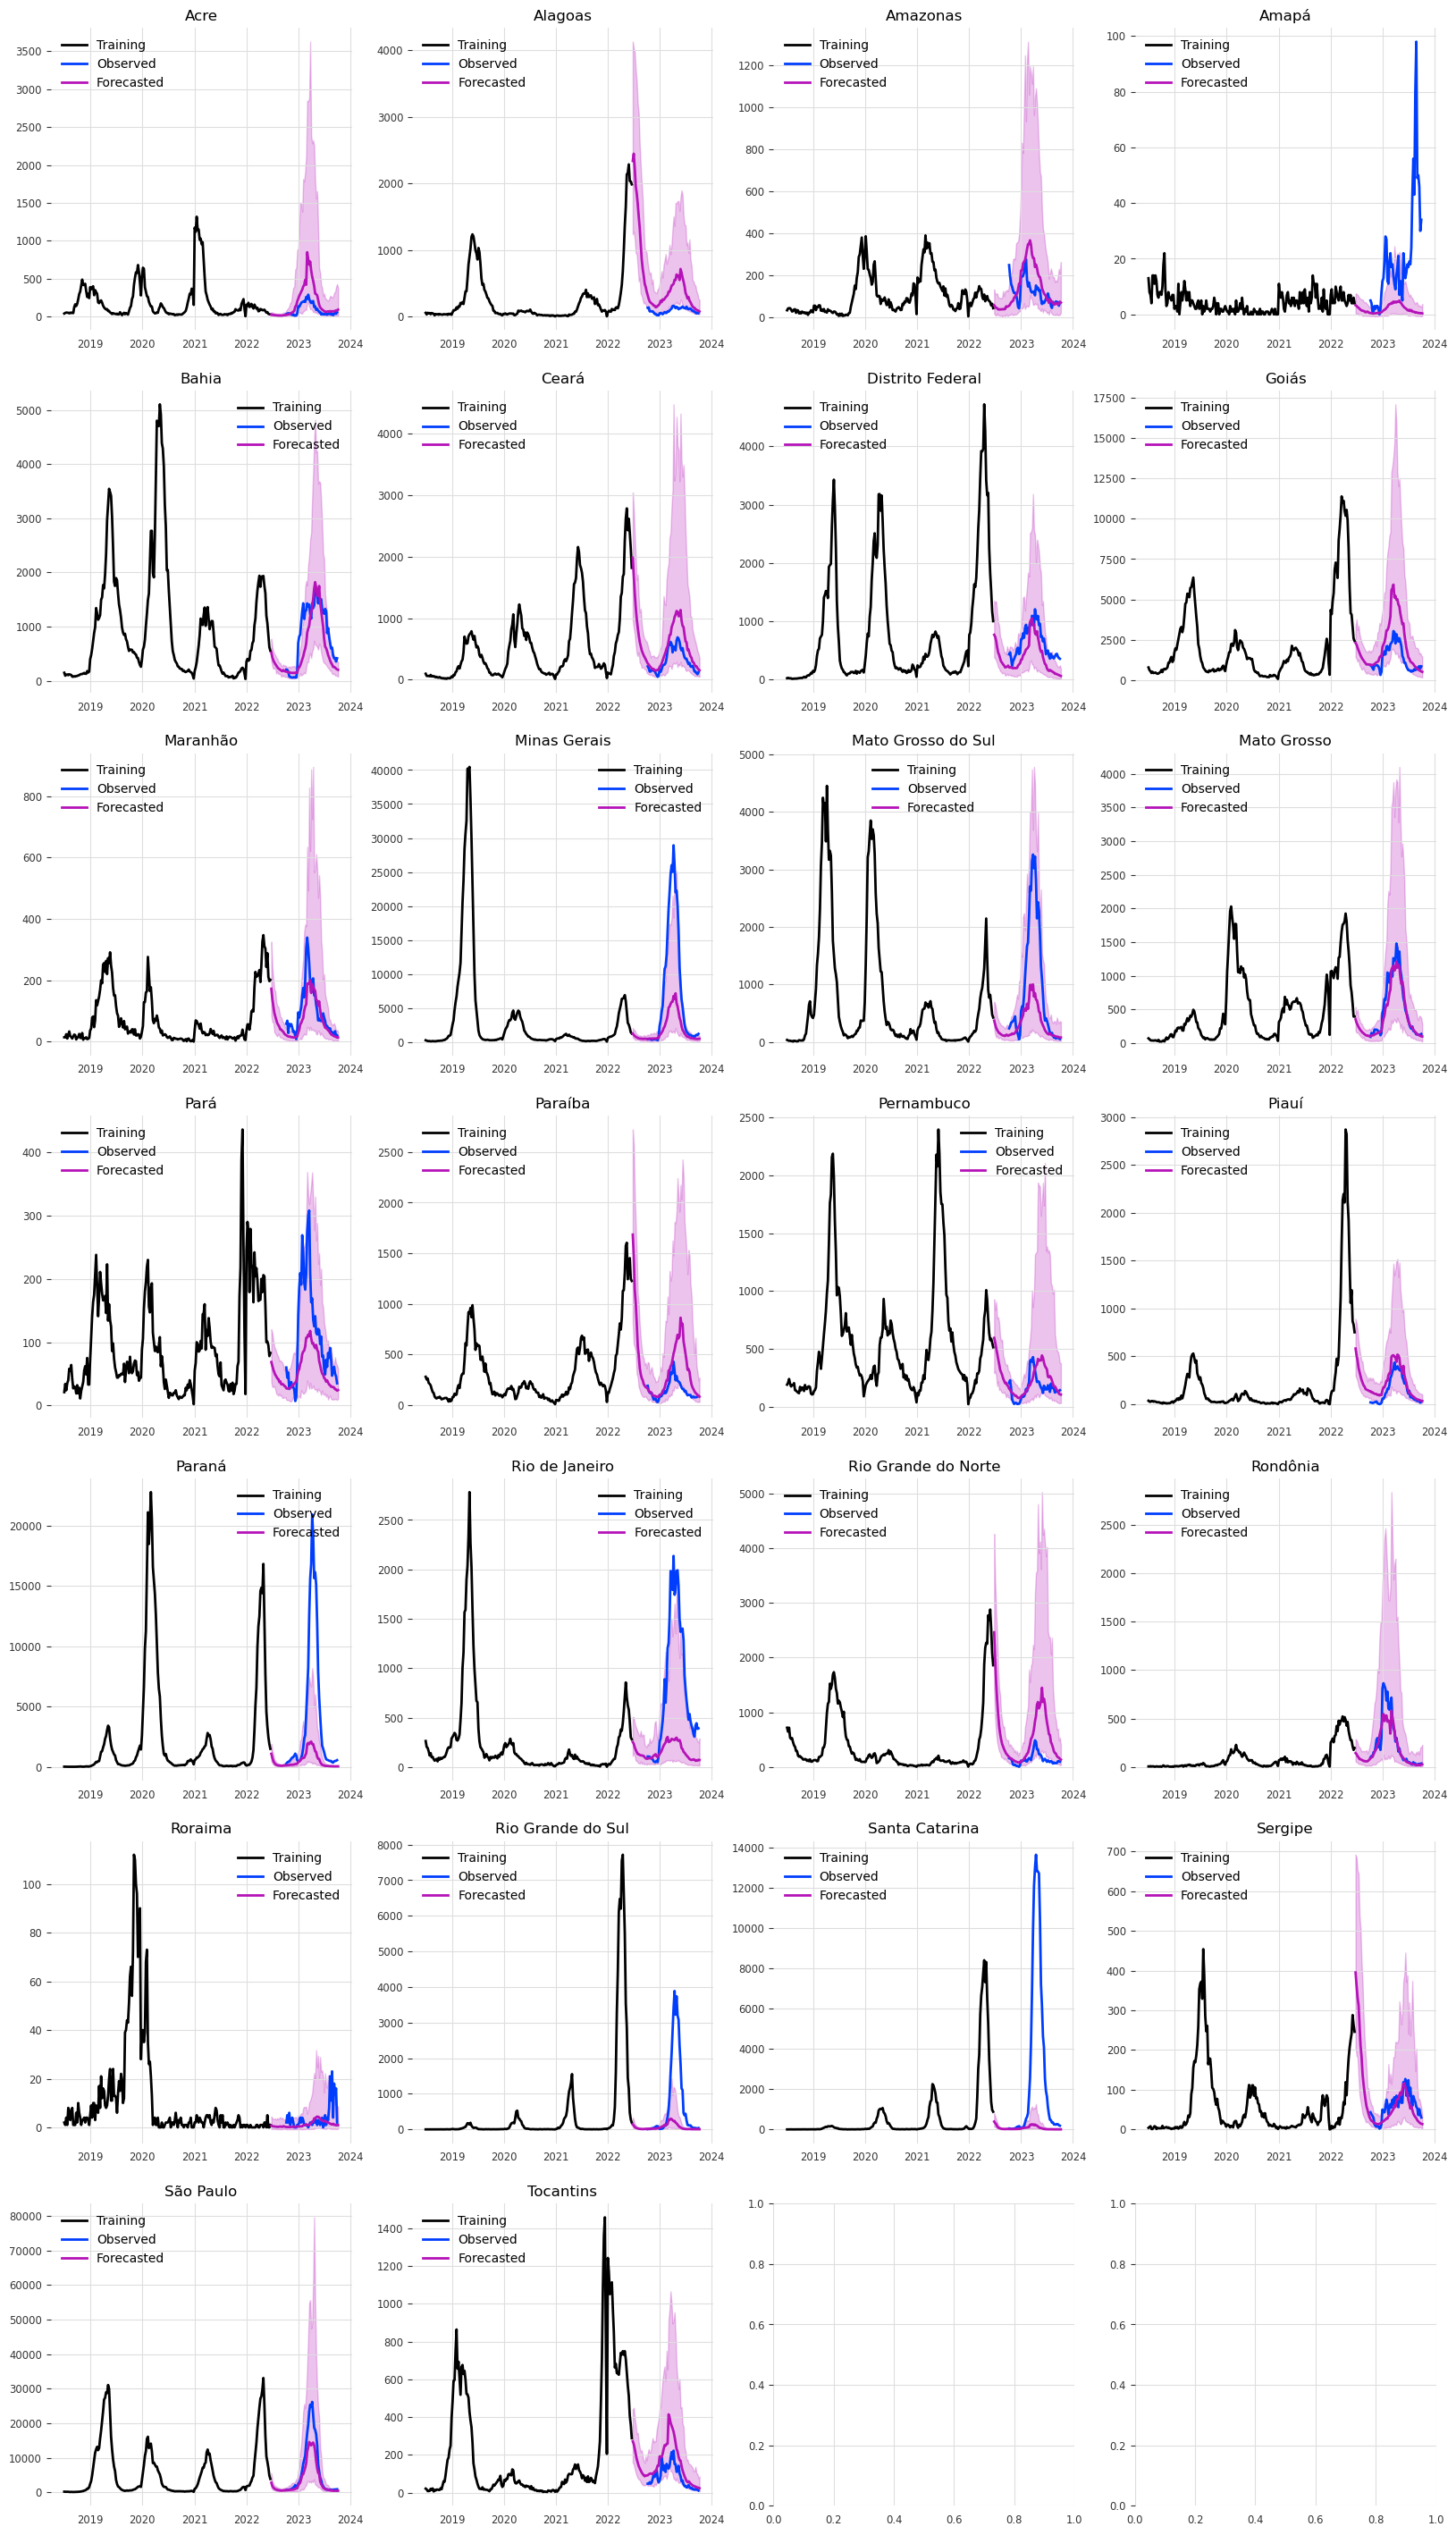

In [42]:
hp.generate_preds_obs_den_plot(hold1, targ1, targ1_preds, uf_list, uf_list, label_list = uf_name_list, train_limit = 208)
plt.savefig(os.path.join(vis_output_dir, "Targ1_GlobalFit=" + str(global_fit) + "_TrainFromScratch=" + str(train_from_scratch) + ".png"), dpi = 600, bbox_inches = "tight")

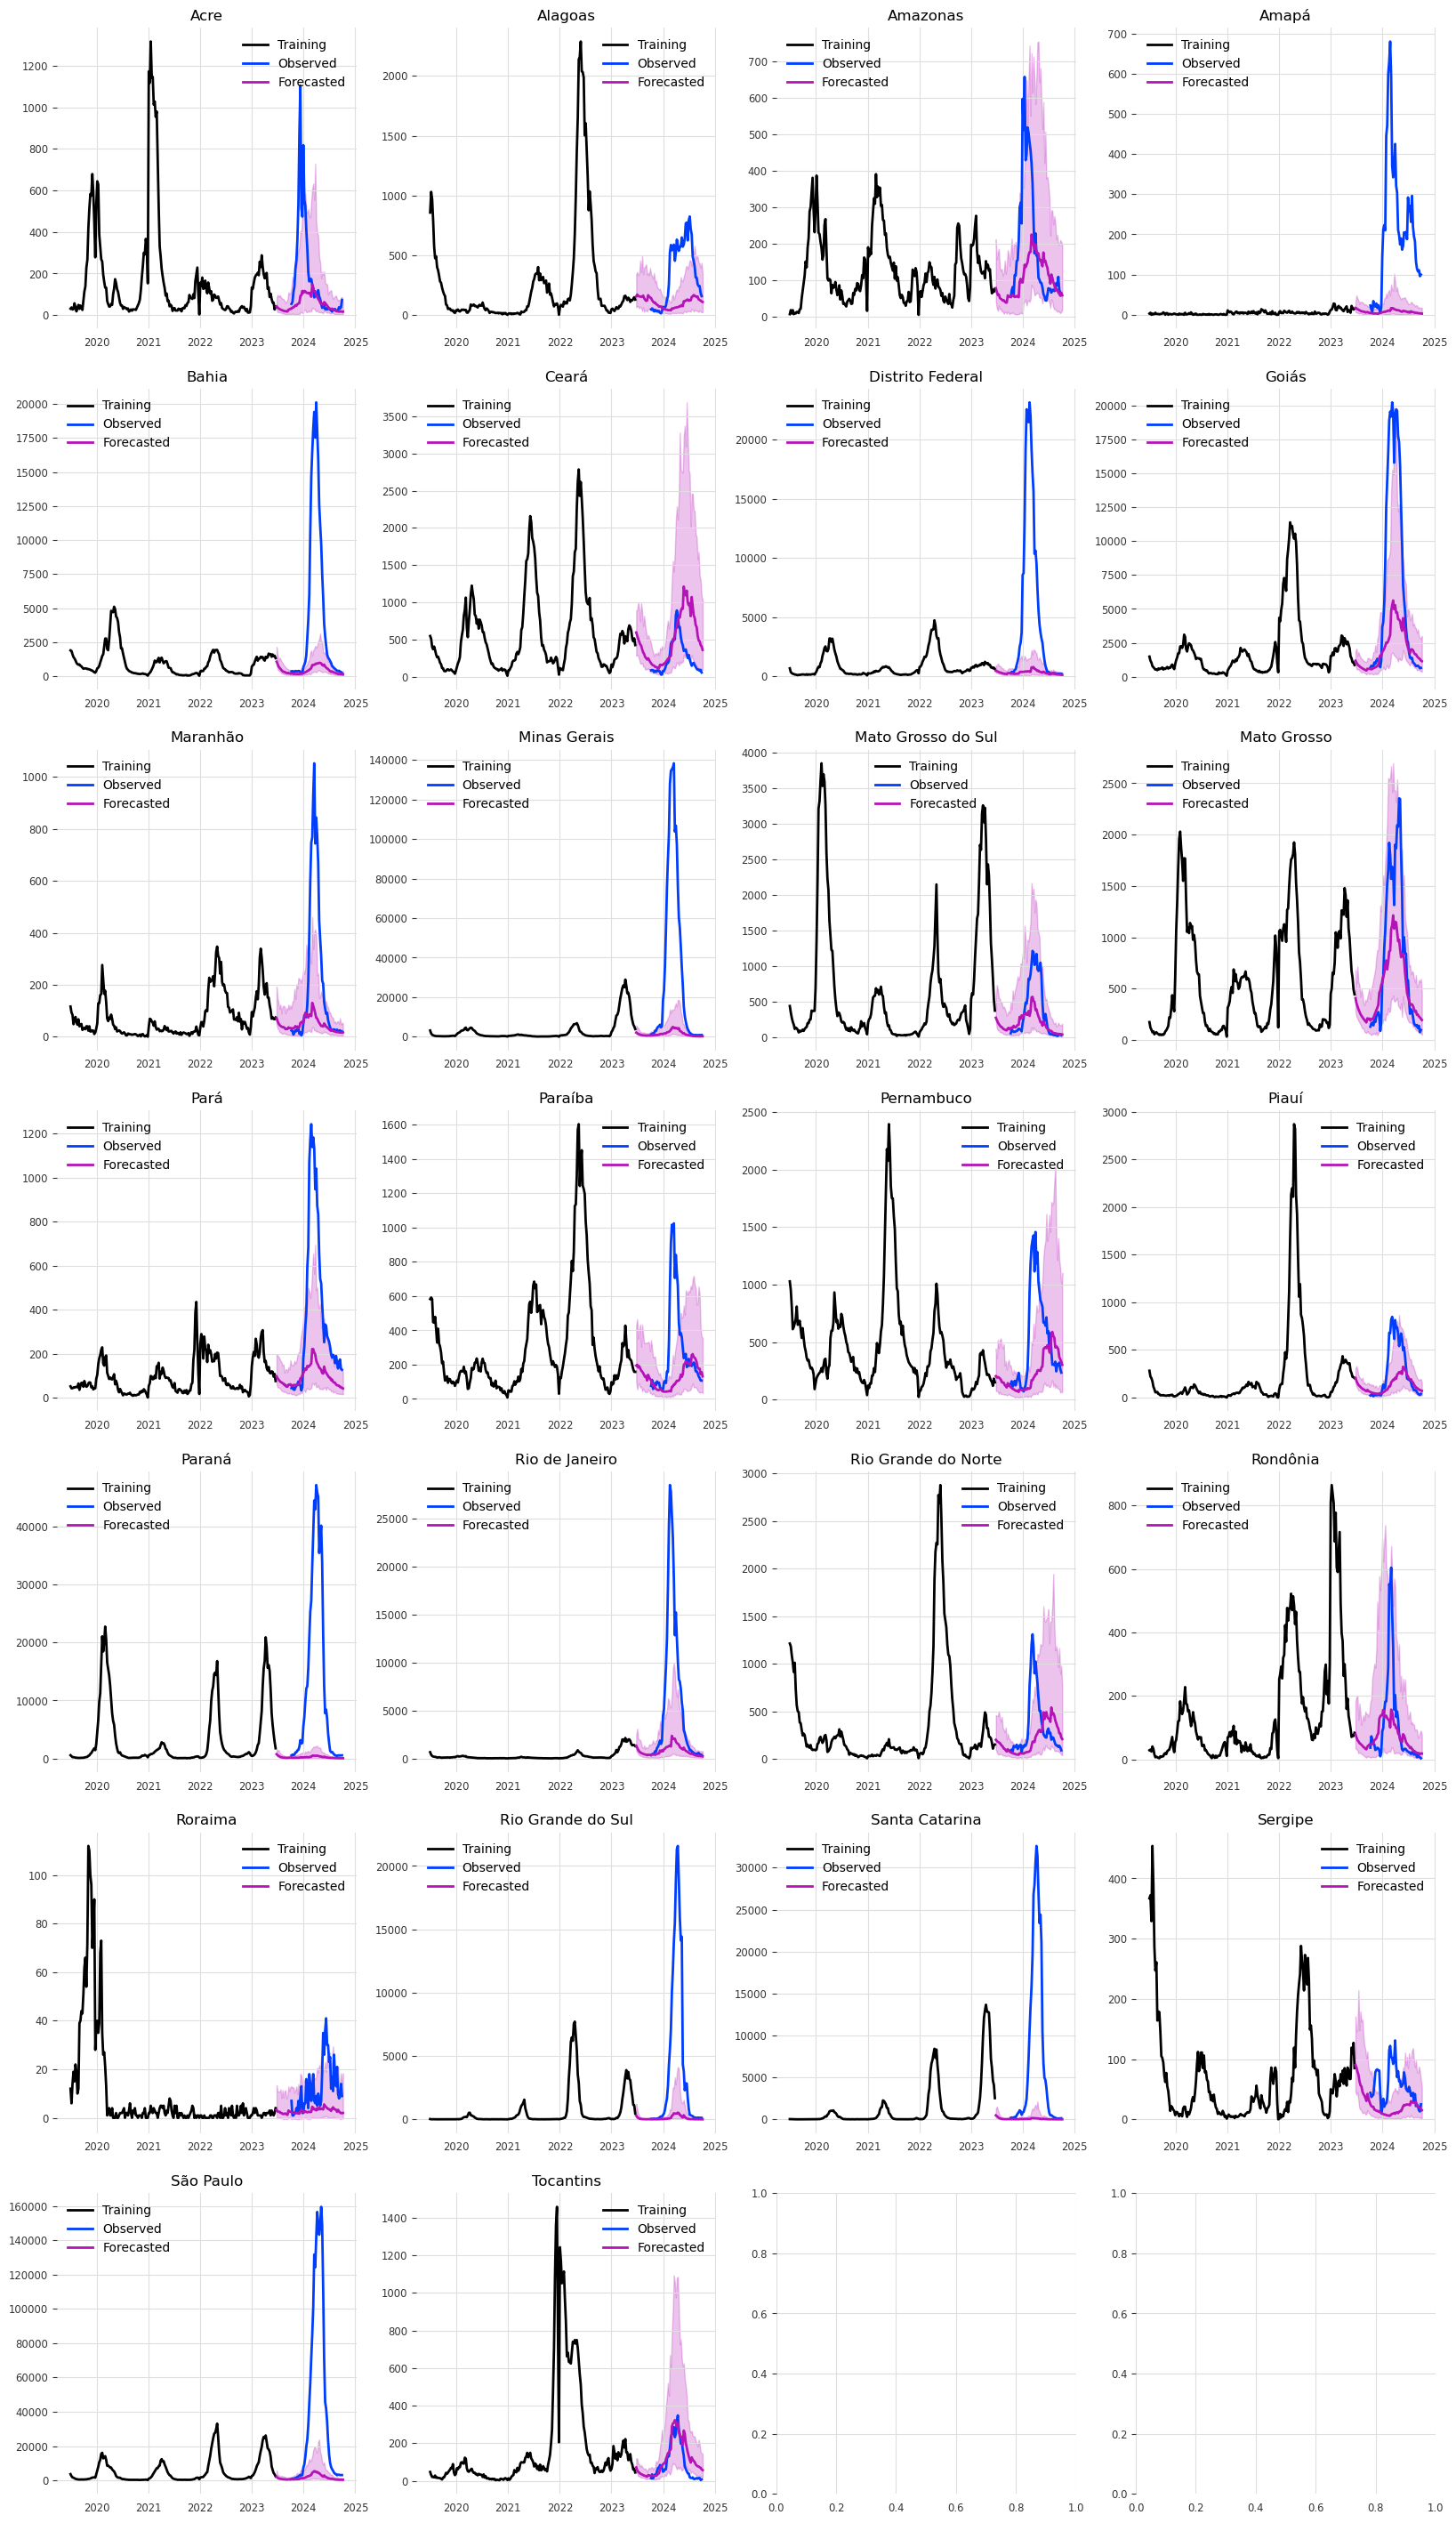

In [43]:
hp.generate_preds_obs_den_plot(hold2, targ2, targ2_preds, uf_list, uf_list, label_list = uf_name_list, train_limit = 208)
plt.savefig(os.path.join(vis_output_dir, "Targ2_GlobalFit=" + str(global_fit) + "_TrainFromScratch=" + str(train_from_scratch) + ".png"), dpi = 600, bbox_inches = "tight")

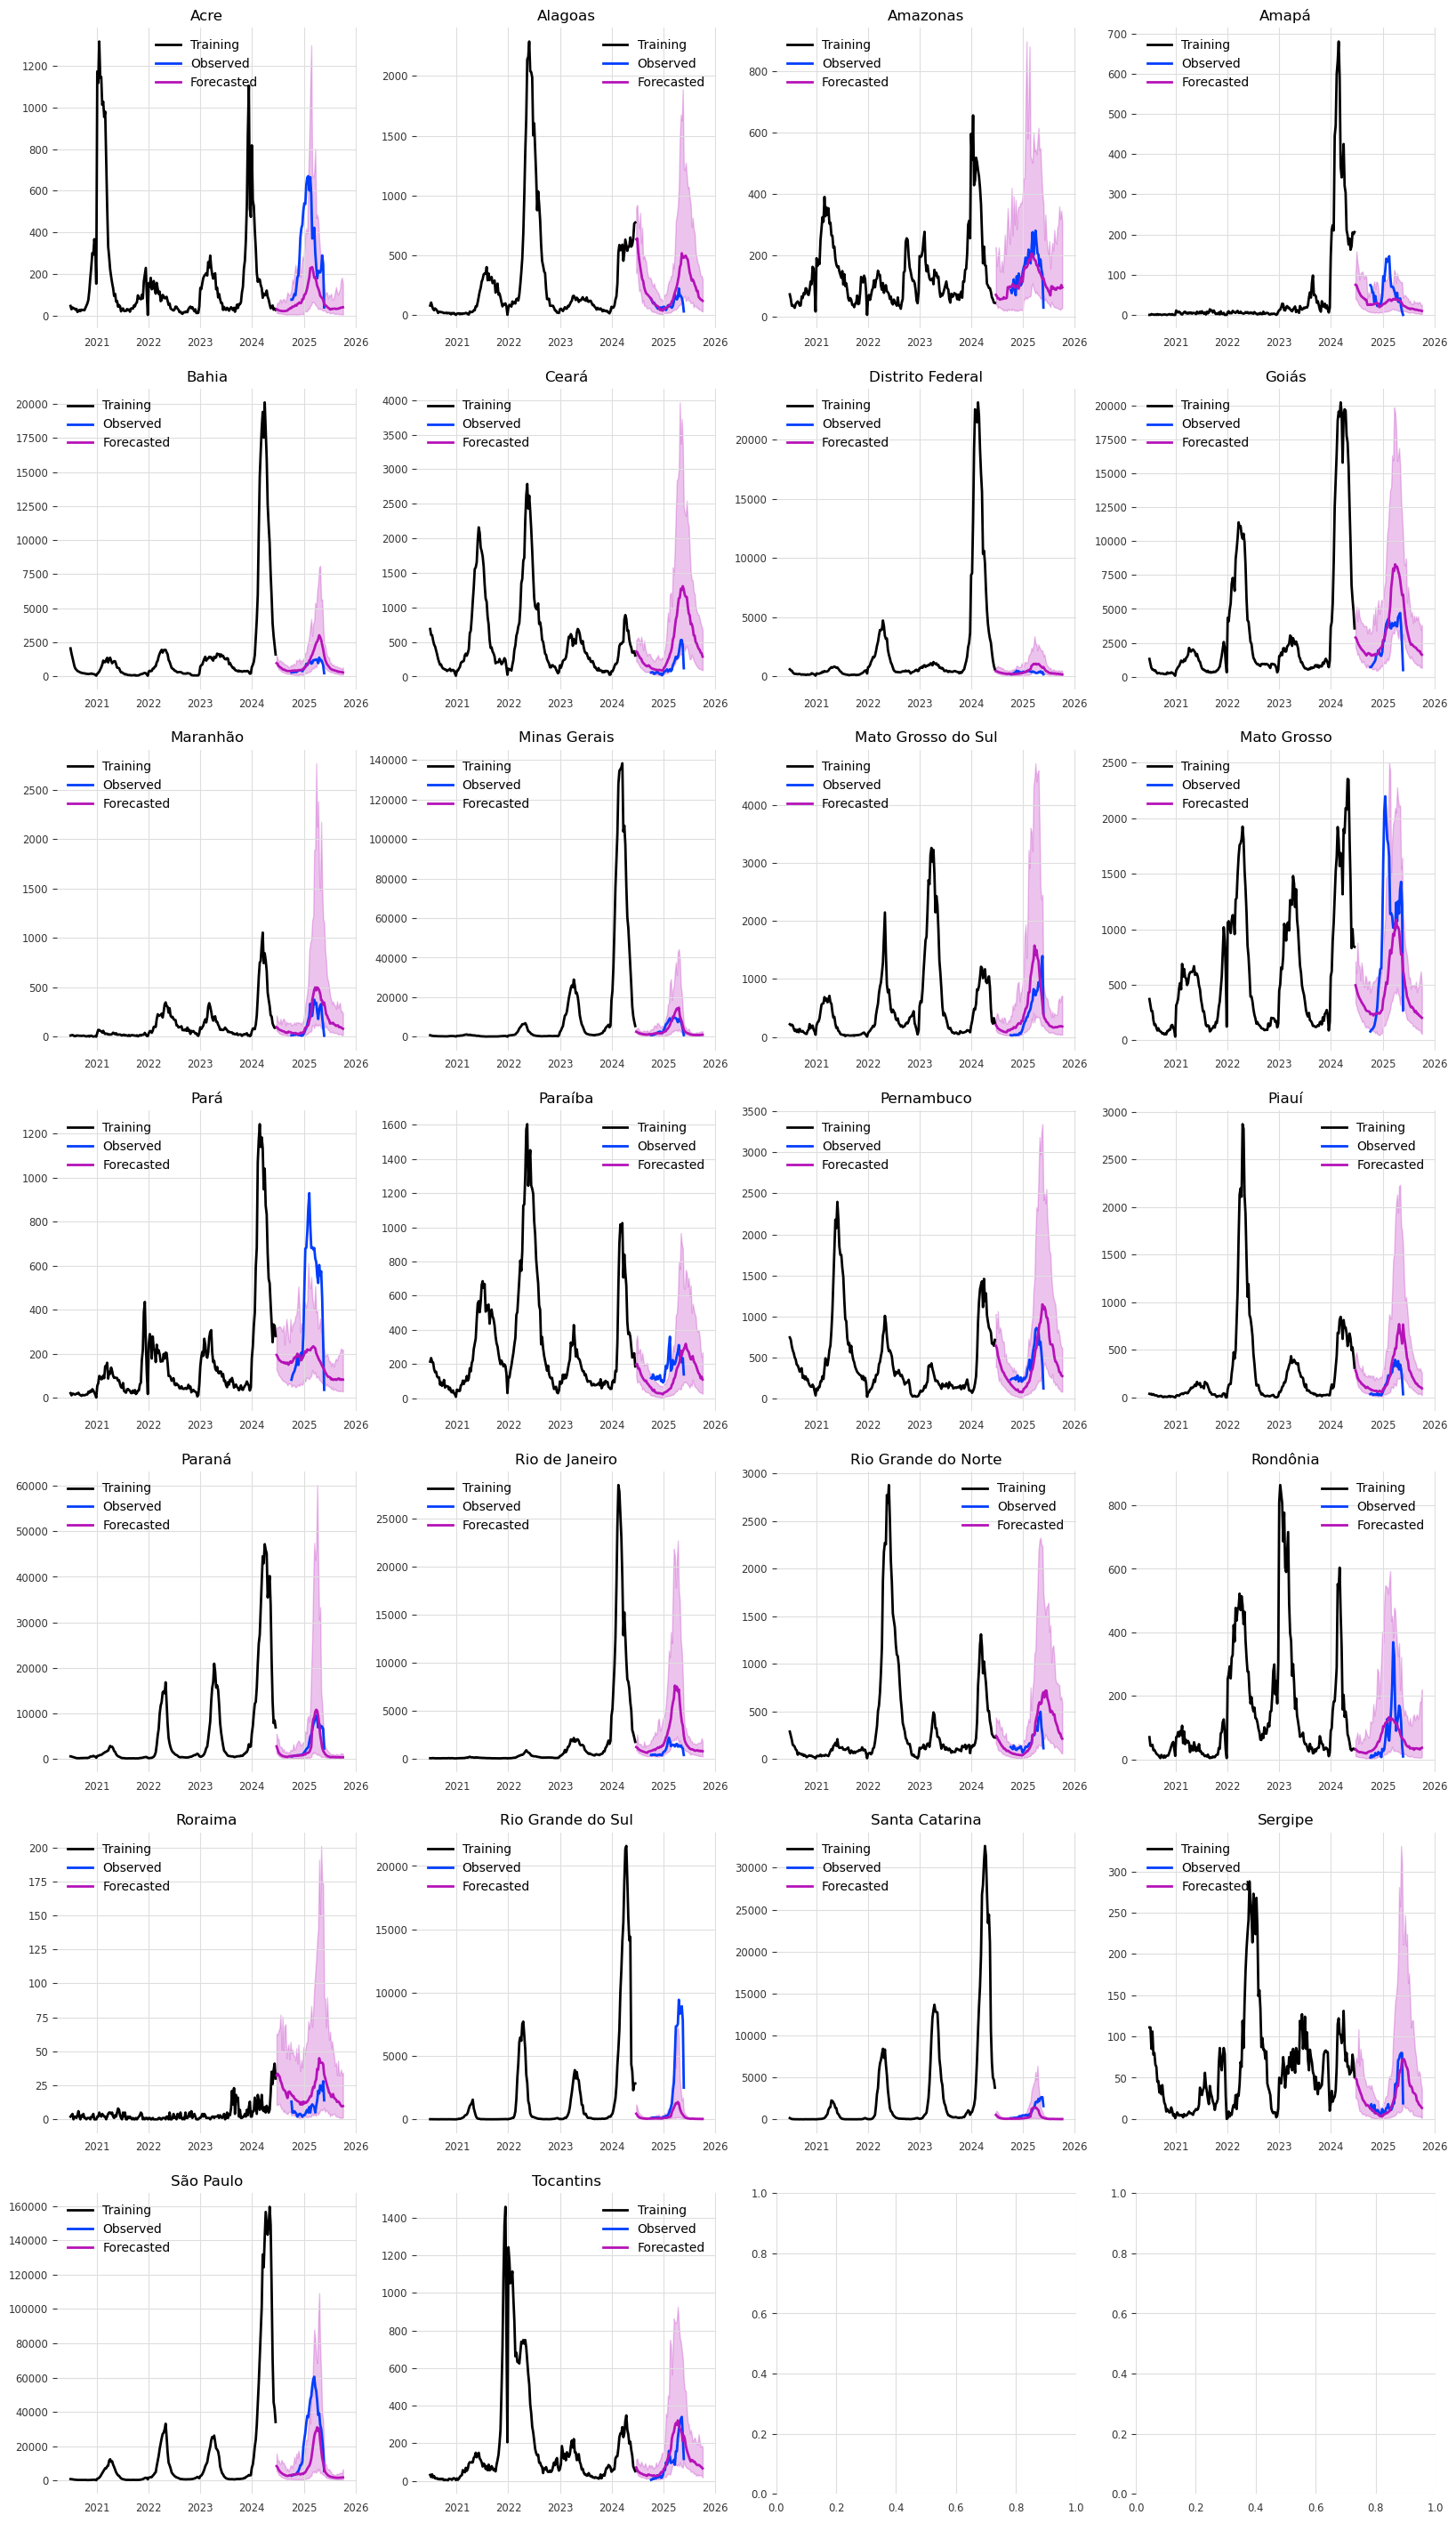

In [44]:
hp.generate_preds_obs_den_plot(hold3, targ3, targ3_preds, uf_list, uf_list, label_list = uf_name_list, train_limit = 208)
plt.savefig(os.path.join(vis_output_dir, "Targ3_GlobalFit=" + str(global_fit) + "_TrainFromScratch=" + str(train_from_scratch) + ".png"), dpi = 600, bbox_inches = "tight")

In [45]:
targ_losses = np.array([loss_targ1, loss_targ2, loss_targ3])

In [46]:
targ_losses

array([0.31252826, 1.14968526, 0.24028995])

In [47]:
np.mean(targ_losses)

0.5675011549708806

## 5. Plots & Metrics

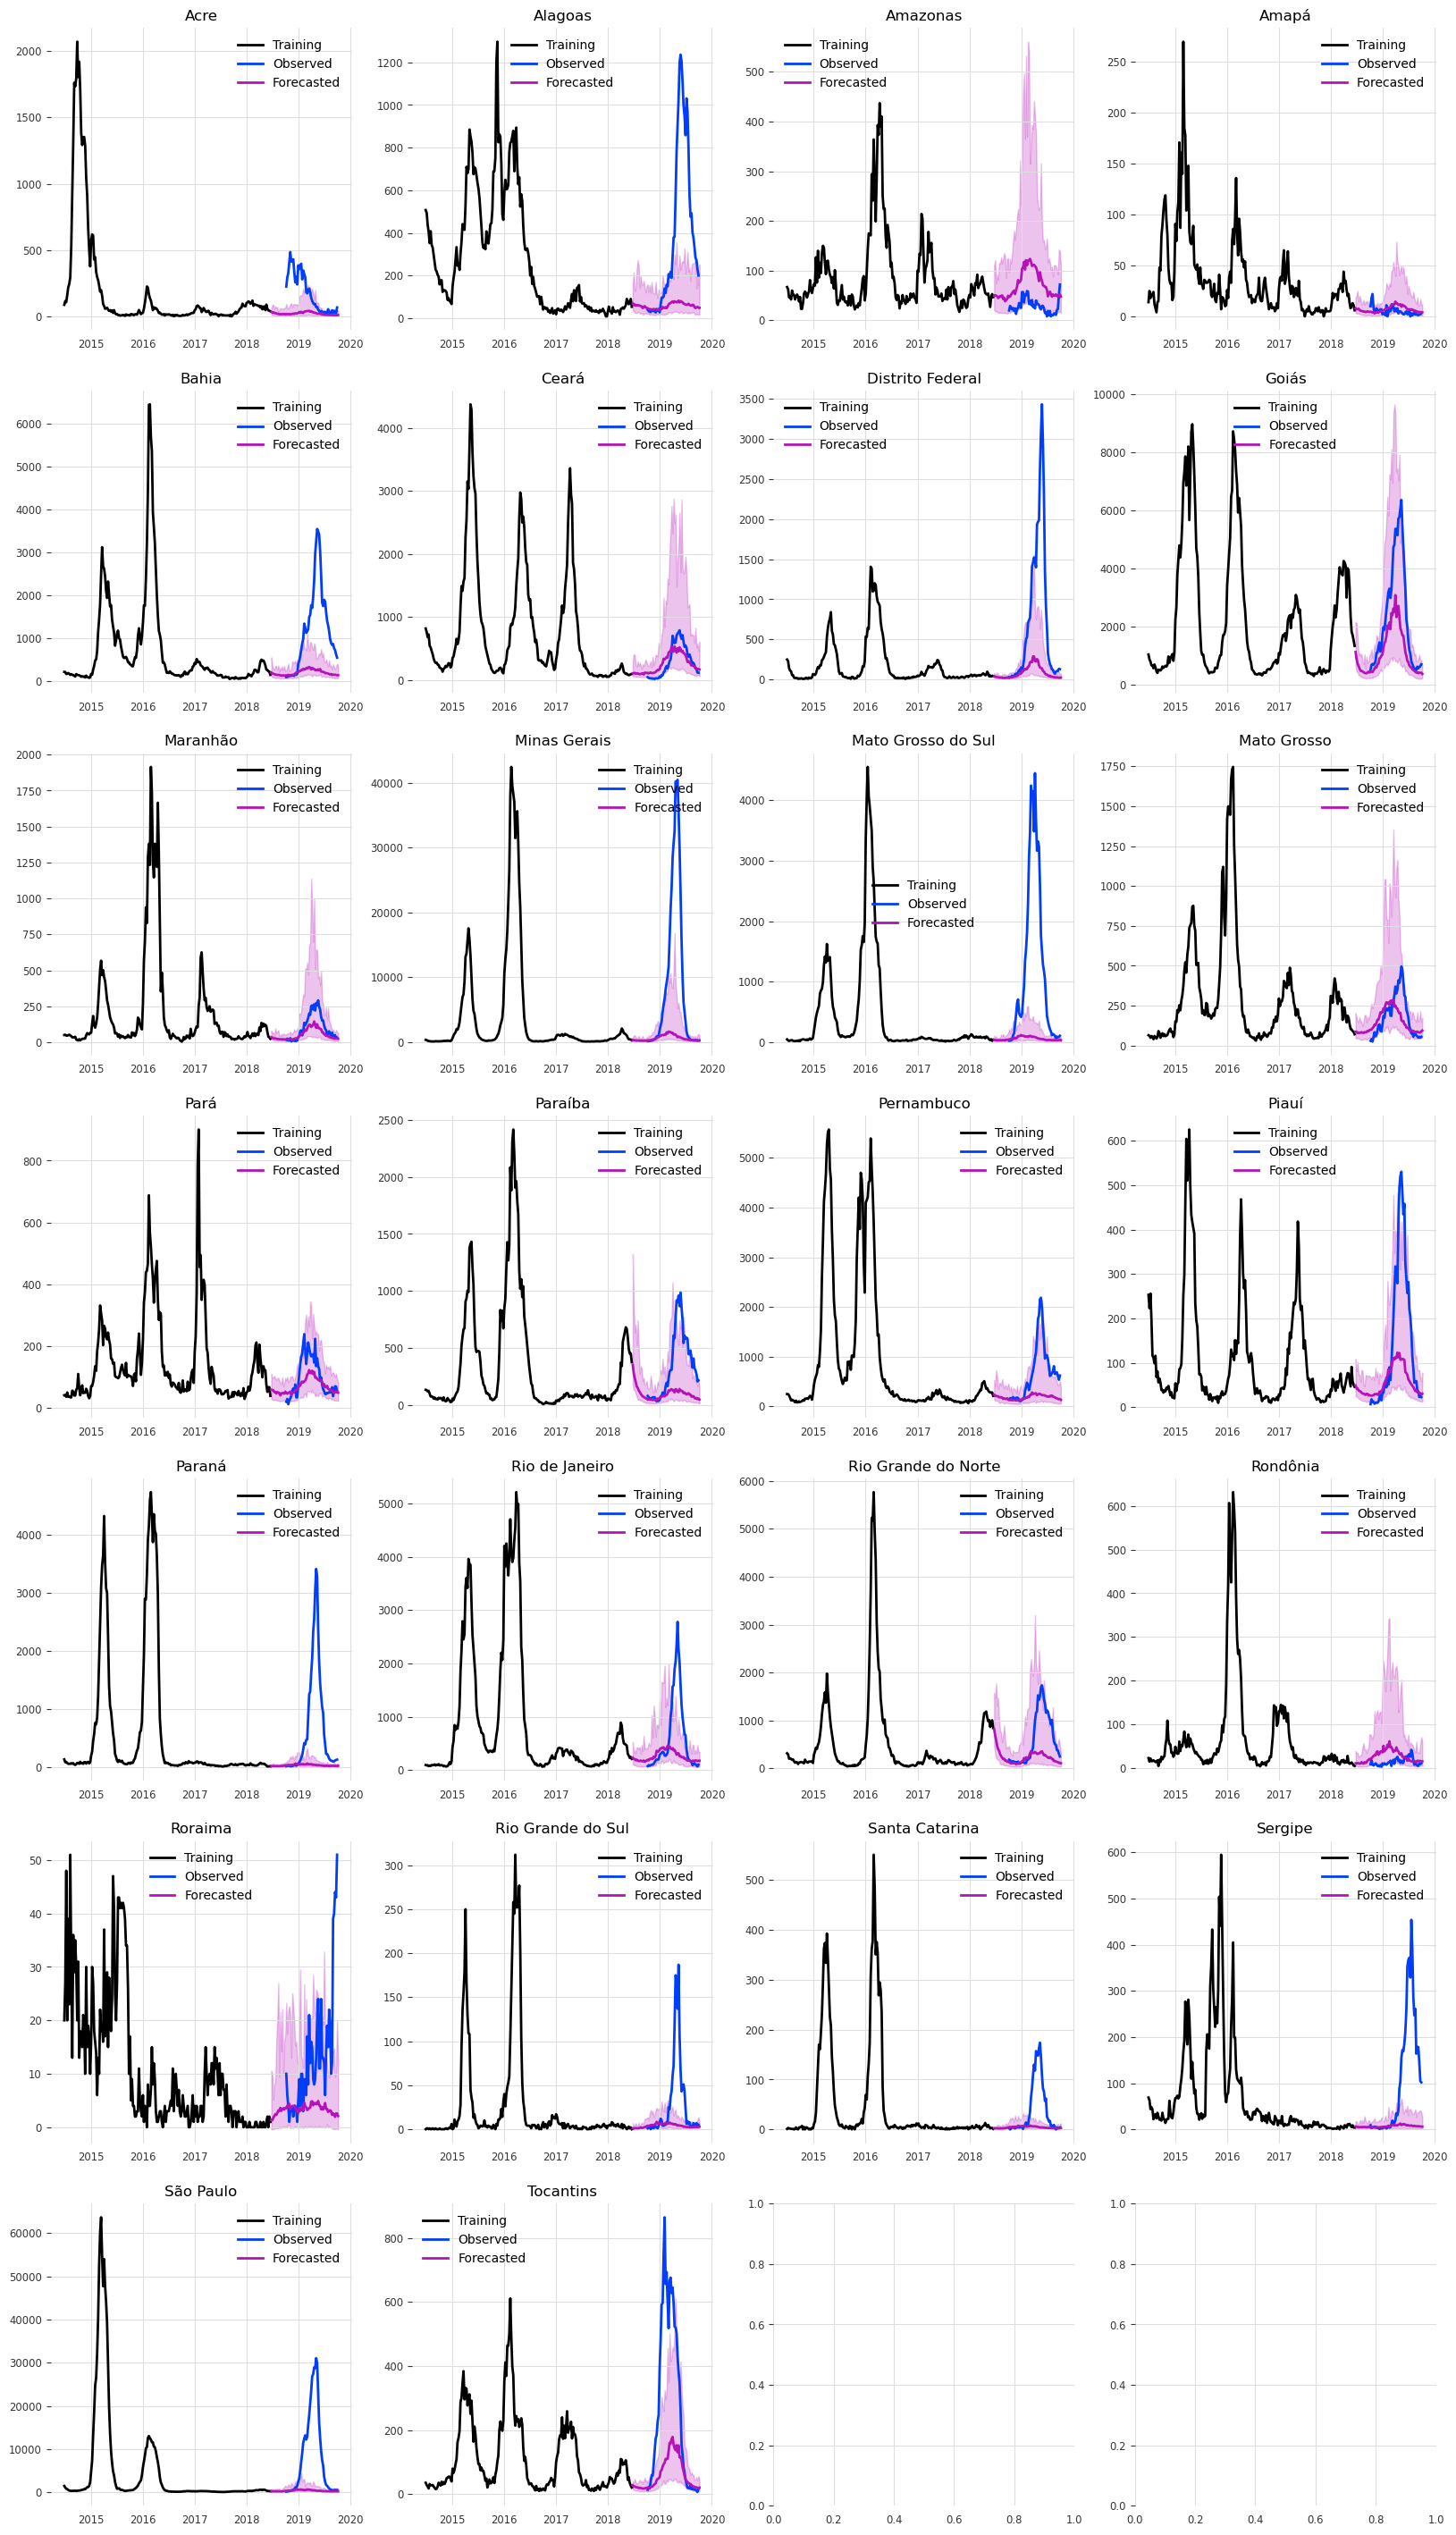

In [48]:
hp.generate_preds_obs_den_plot(train1a, val1a, val1a_mod1a_predict, uf_list, uf_list, label_list = uf_name_list, train_limit = 208)

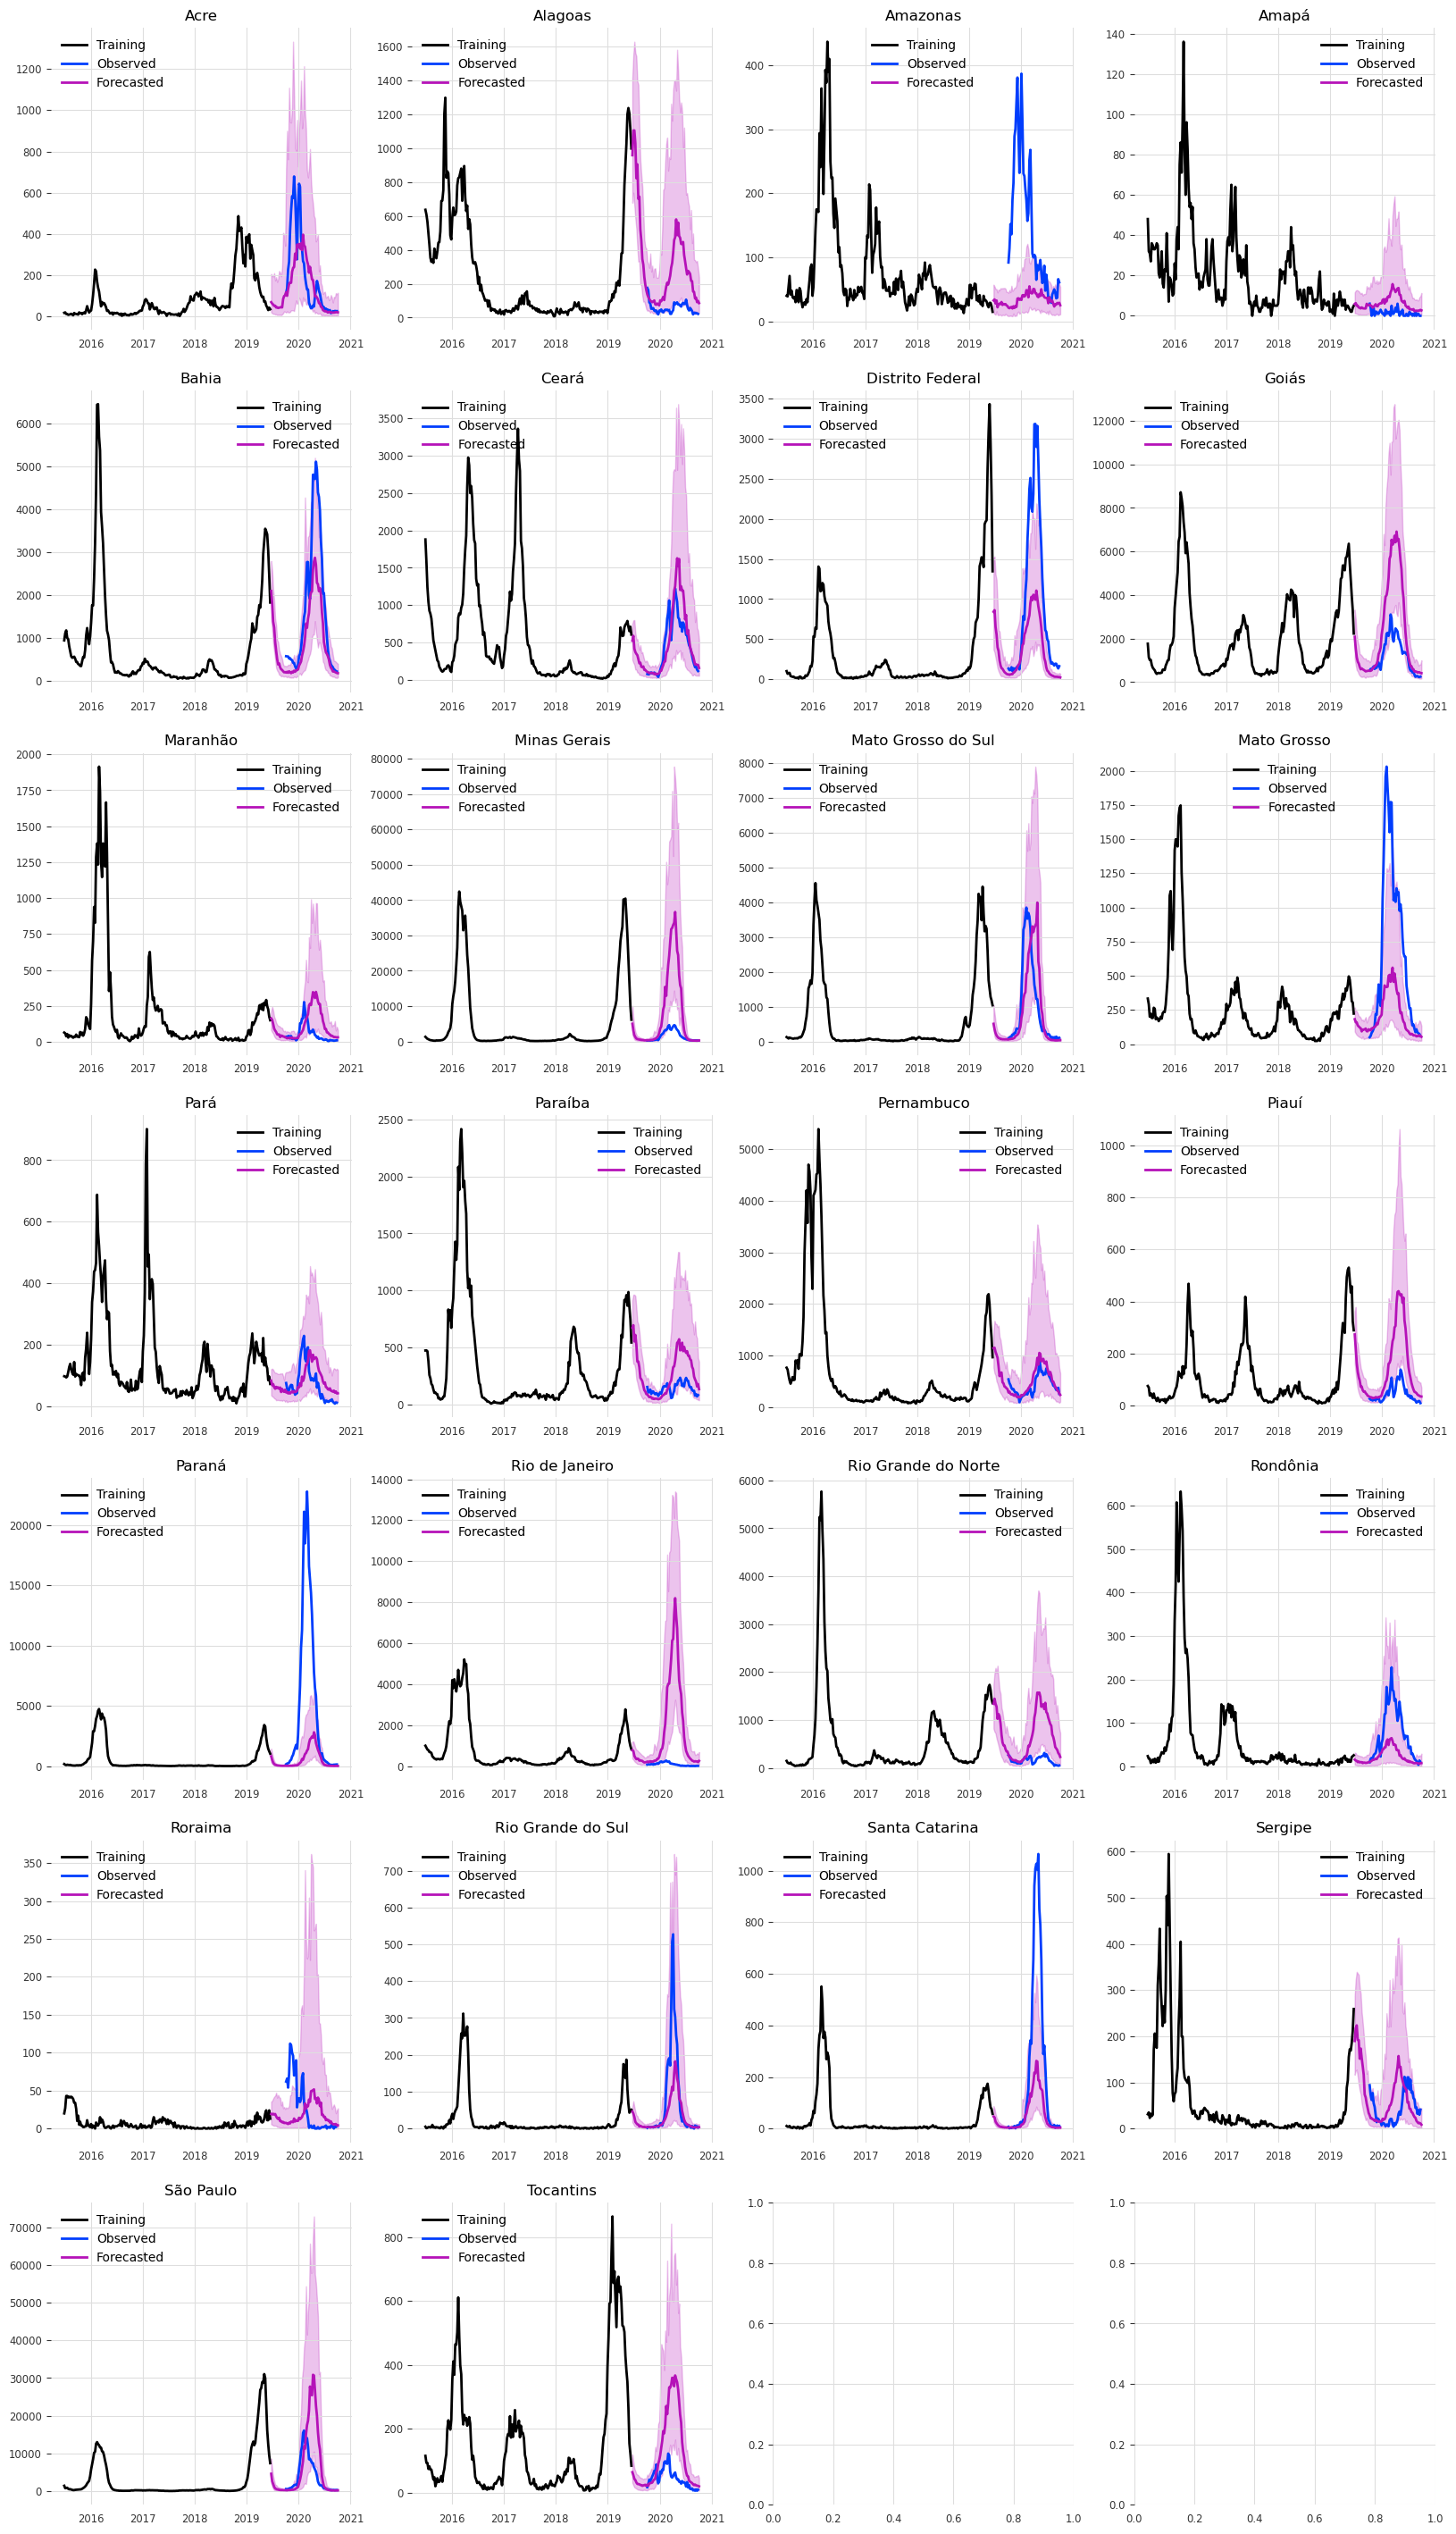

In [49]:
hp.generate_preds_obs_den_plot(train1b, val1b, val1b_mod1b_predict, uf_list, uf_list, label_list = uf_name_list, train_limit = 208)

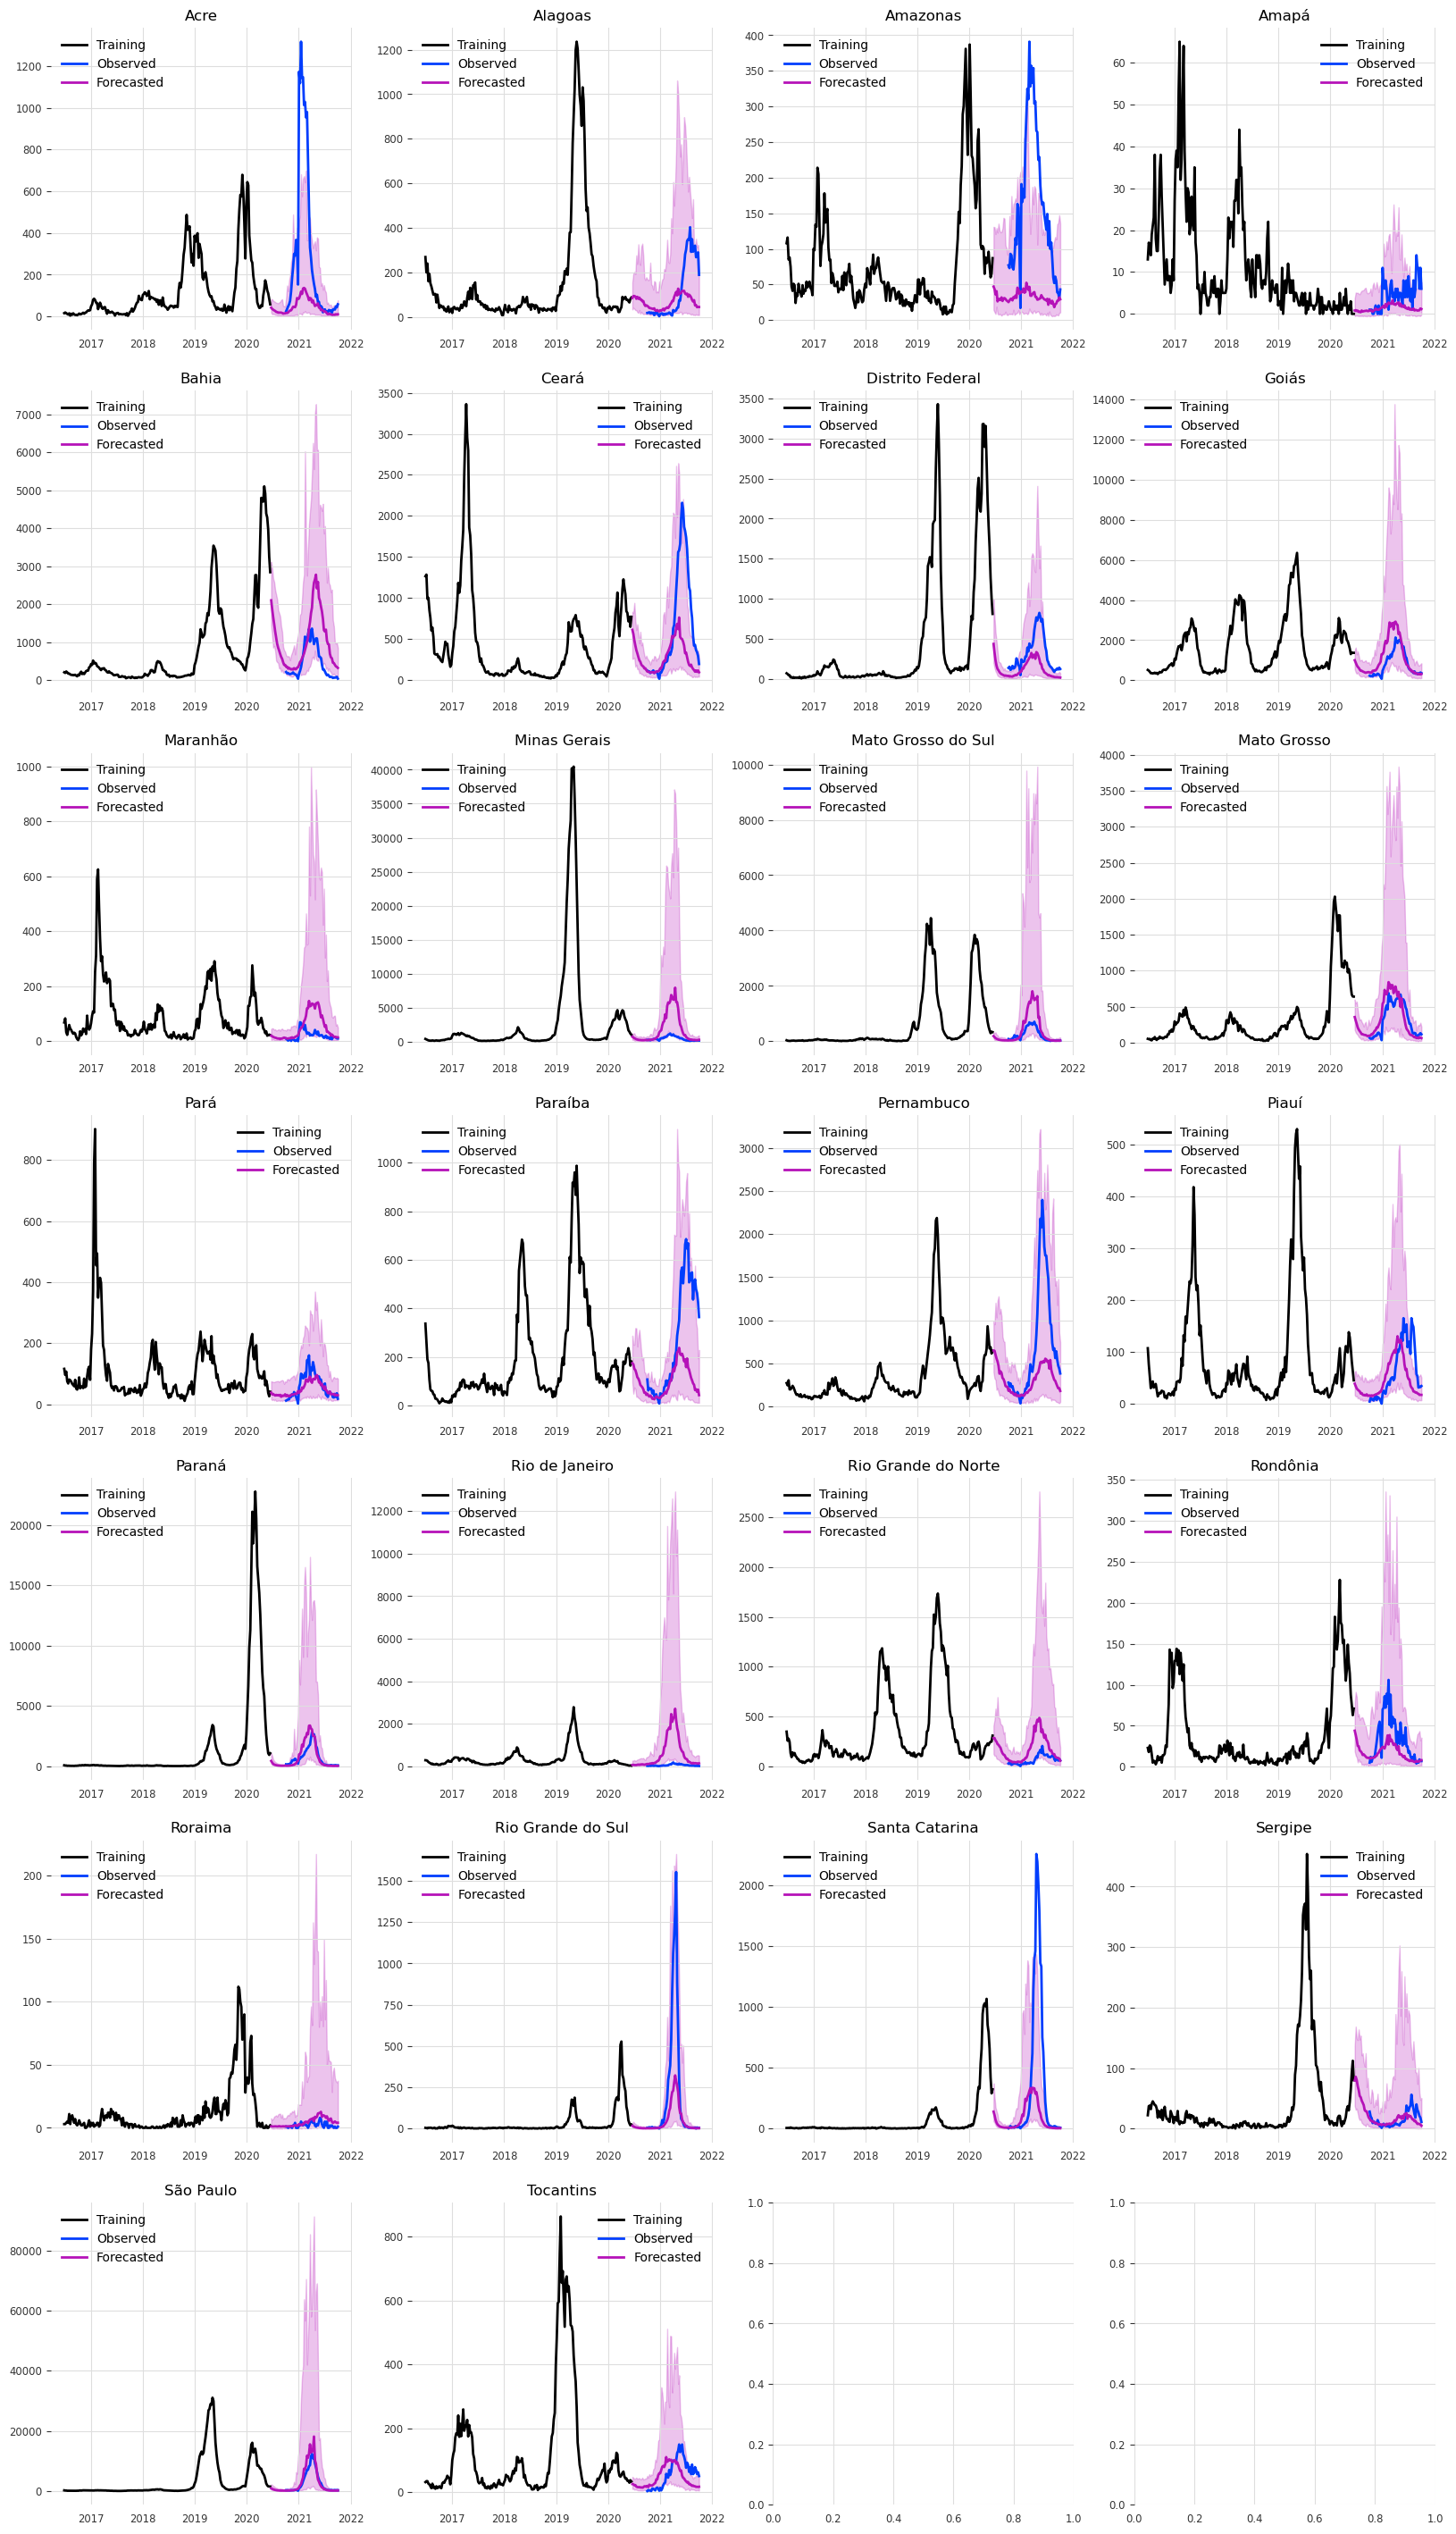

In [50]:
hp.generate_preds_obs_den_plot(train1c, val1c, val1c_mod1c_predict, uf_list, uf_list, label_list = uf_name_list, train_limit = 208)